In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import sweetviz

import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters

from sklearn.impute import KNNImputer
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv("Backorder_Training_Dataset.csv")
test = pd.read_csv("Backorder_Test_Dataset.csv")

In [3]:
train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

In [5]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
national_inv,1687860.0,496.111782,29615.233831,-27256.0,4.00,15.00,80.00,12334404.0
lead_time,1586967.0,7.872267,7.056024,0.0,4.00,8.00,9.00,52.0
in_transit_qty,1687860.0,44.052022,1342.741731,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1687860.0,178.119284,5026.553102,0.0,0.00,0.00,4.00,1427612.0
forecast_6_month,1687860.0,344.986664,9795.151861,0.0,0.00,0.00,12.00,2461360.0
forecast_9_month,1687860.0,506.364431,14378.923562,0.0,0.00,0.00,20.00,3777304.0
sales_1_month,1687860.0,55.926069,1928.195879,0.0,0.00,0.00,4.00,741774.0
sales_3_month,1687860.0,175.025930,5192.377625,0.0,0.00,1.00,15.00,1105478.0
sales_6_month,1687860.0,341.728839,9613.167104,0.0,0.00,2.00,31.00,2146625.0
sales_9_month,1687860.0,525.269701,14838.613523,0.0,0.00,4.00,47.00,3205172.0


In [6]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
national_inv,242075.0,499.751028,29280.390793,-25414.0,4.00,15.00,81.00,12145792.0
lead_time,227351.0,7.923018,7.041410,0.0,4.00,8.00,9.00,52.0
in_transit_qty,242075.0,36.178213,898.673127,0.0,0.00,0.00,0.00,265272.0
forecast_3_month,242075.0,181.472345,5648.874620,0.0,0.00,0.00,4.00,1510592.0
forecast_6_month,242075.0,348.807304,10081.797119,0.0,0.00,0.00,12.00,2157024.0
forecast_9_month,242075.0,508.296301,14109.723787,0.0,0.00,0.00,20.00,3162260.0
sales_1_month,242075.0,51.478195,1544.678350,0.0,0.00,0.00,4.00,349620.0
sales_3_month,242075.0,172.139316,5164.243624,0.0,0.00,1.00,14.00,1099852.0
sales_6_month,242075.0,340.425414,9386.523492,0.0,0.00,2.00,30.00,2103389.0
sales_9_month,242075.0,511.775446,13976.702192,0.0,0.00,4.00,46.00,3195211.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

In [8]:
print(train.shape)
print(test.shape)

(1687861, 23)
(242076, 23)


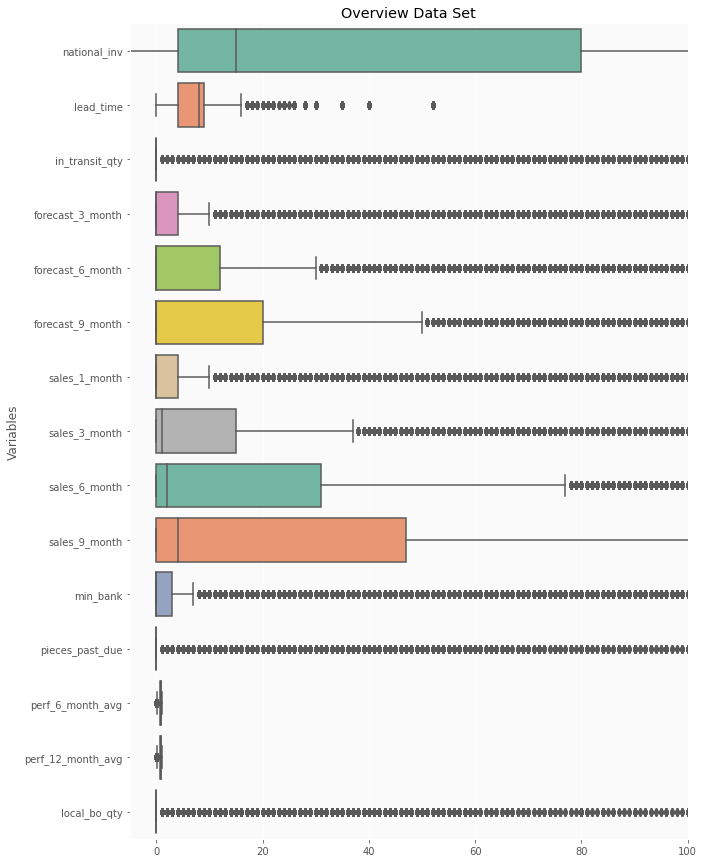

In [9]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(10, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-5, 100))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = train.drop(columns=['sku']), 
  orient = 'h', 
  palette = 'Set2')

In [10]:
train.tail(2)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,...,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
test.tail(2)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
242074,3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242075,(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Last row of train and test dataset have all columns NaN. Drop this row.

In [12]:
train.drop(index=train.shape[0]-1, axis=0, inplace=True)
test.drop(index=test.shape[0]-1, axis=0, inplace=True)

#### Check unique values in training set

In [13]:
train.nunique()

sku                  1687860
national_inv           14969
lead_time                 32
in_transit_qty          5230
forecast_3_month        7825
forecast_6_month       11114
forecast_9_month       13662
sales_1_month           5764
sales_3_month          10495
sales_6_month          14818
sales_9_month          18341
min_bank                5568
potential_issue            2
pieces_past_due          826
perf_6_month_avg         102
perf_12_month_avg        102
local_bo_qty             654
deck_risk                  2
oe_constraint              2
ppap_risk                  2
stop_auto_buy              2
rev_stop                   2
went_on_backorder          2
dtype: int64

In [14]:
### sku feature is unique for rach obervations and doesn't add any information. So, droping this feature from the train and test dataset
train.drop(columns='sku', axis=1, inplace=True)
test.drop(columns='sku', axis=1, inplace=True)

#### Checking for duplicate rows in the dataset

In [15]:
print('In train dataset there are ',train.duplicated().sum(),' rows that have same values as another row from the data')
print('In test dataset there are ',test.duplicated().sum(),' rows that have same values as another row from the data')

In train dataset there are  667552  rows that have same values as another row from the data
In test dataset there are  56552  rows that have same values as another row from the data


#### There are 667552  and 56552 rows in train and test dataset which have the exact same values as another row from the data, these are duplicate records. All these duplicated rows will be dropped considering train time complexity and also training a ML model on repeated data will not contribute much information to the loss. Even, predicting the same row again which testing the modeling may impact the metric score.

In [16]:
#removing duplicate rows from train dataset
print('No.of rows in dataframe before removing duplicates:',train.shape[0])
train.drop_duplicates(inplace = True, ignore_index=True)
print('No.of rows in dataframe after removing duplicates:',train.shape[0])

No.of rows in dataframe before removing duplicates: 1687860
No.of rows in dataframe after removing duplicates: 1020308


In [17]:
#removing duplicate rows from test dataset
print('No.of rows in dataframe before removing duplicates:',test.shape[0])
test.drop_duplicates(inplace = True, ignore_index=True)
print('No.of rows in dataframe after removing duplicates:',test.shape[0])

No.of rows in dataframe before removing duplicates: 242075
No.of rows in dataframe after removing duplicates: 185523


In [18]:
print(train.shape)
print(test.shape)

(1020308, 22)
(185523, 22)


#### Check missing values in dataset

<AxesSubplot:>

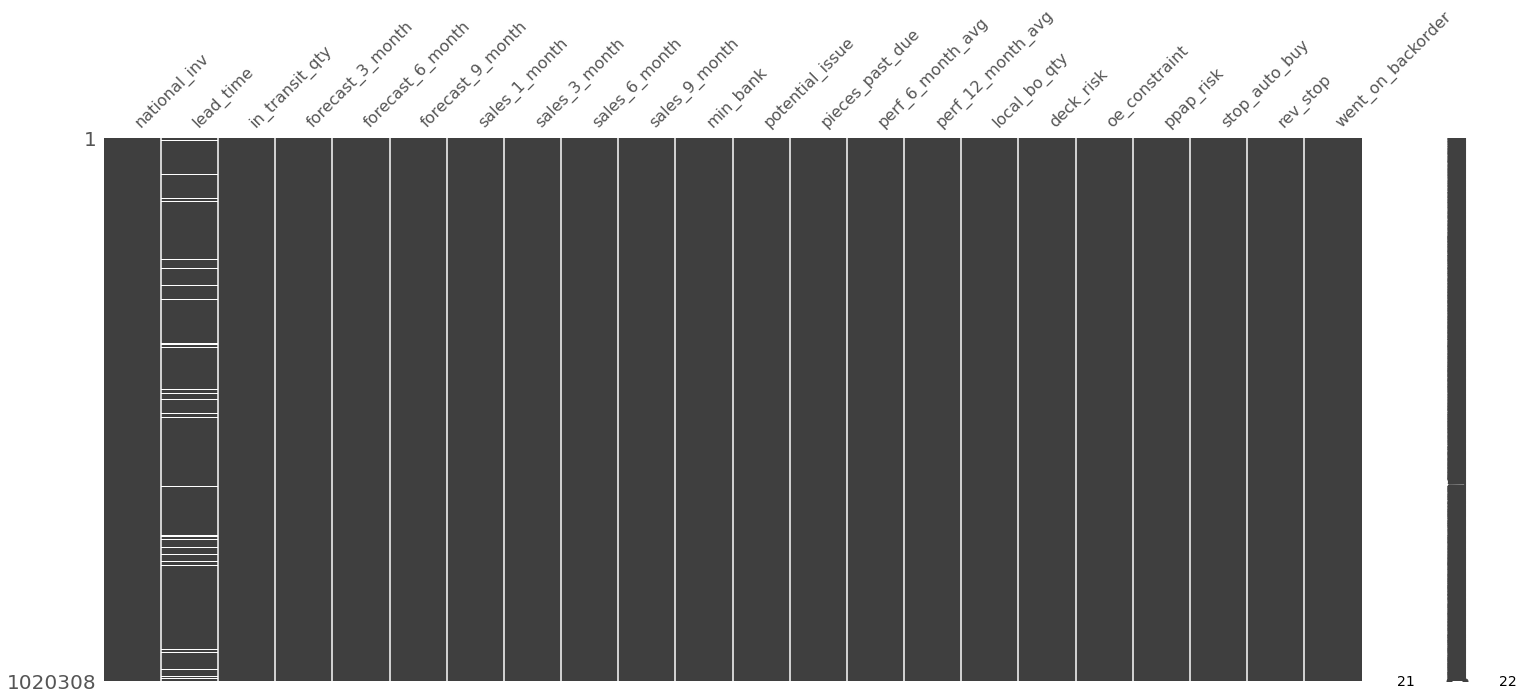

In [19]:
msno.matrix(train)

<AxesSubplot:>

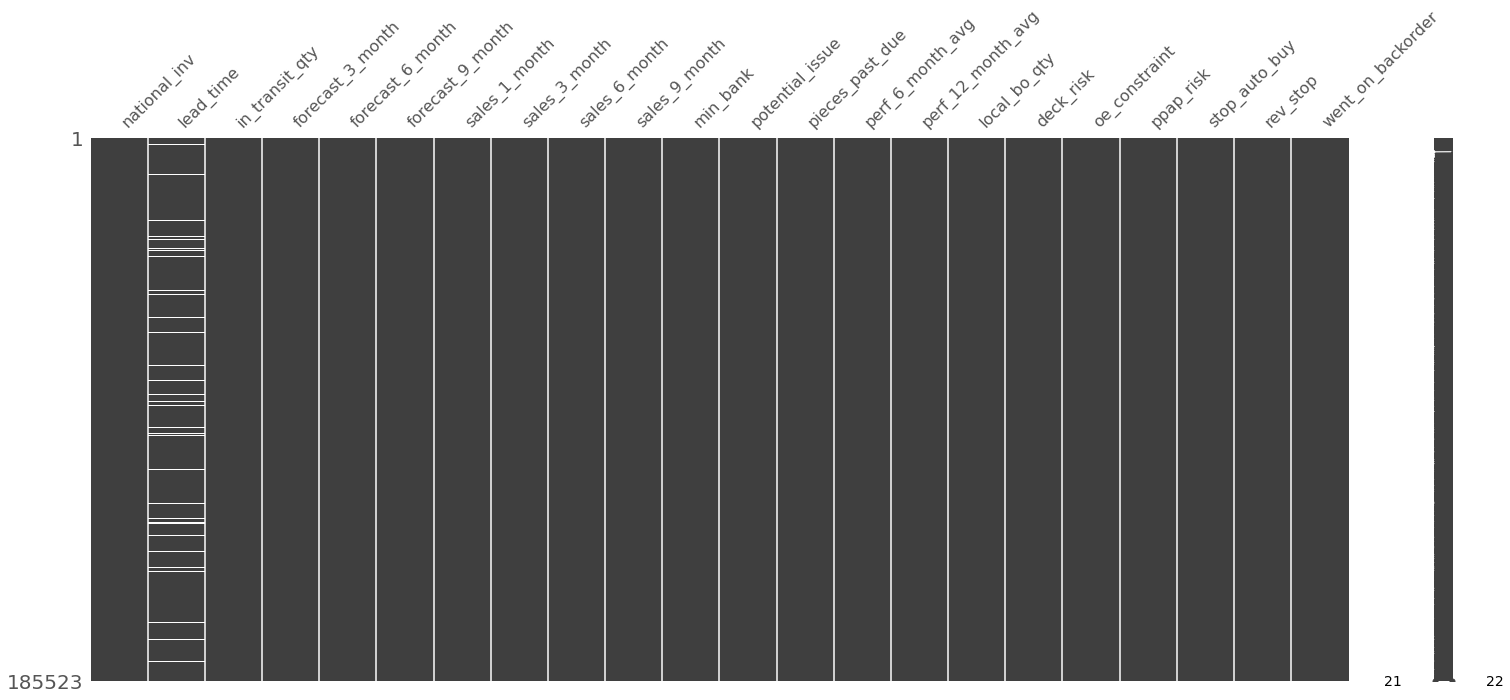

In [20]:
msno.matrix(test)

#### Only lead_time feature have missing value

In [21]:
print("Train data", train.columns[train.isnull().any()])
print("Test data", test.columns[test.isnull().any()])

Train data Index(['lead_time'], dtype='object')
Test data Index(['lead_time'], dtype='object')


In [22]:
round(train.isnull().sum()/len(train.index)*100,2)['lead_time']

4.0

In [23]:
round(test.isnull().sum()/len(test.index)*100,2)['lead_time']

5.16

In [24]:
pd.set_option('display.float_format', lambda x : '%.5f' % x)

In [25]:
train.lead_time.describe(include='all')

count   979471.00000
mean         7.71099
std          7.19003
min          0.00000
25%          4.00000
50%          8.00000
75%          8.00000
max         52.00000
Name: lead_time, dtype: float64

#### Imputing lead_time with KNN imputer

In [26]:
#train['lead_time']= KNNImputer(n_neighbors=1).fit_transform(train.lead_time.values.reshape(-1,1))
#train['lead_time']= KNNImputer(n_neighbors=1).fit_transform(train.lead_time.values.reshape(-1,1))
train['lead_time'] = train['lead_time'].fillna(train.lead_time.median())
test['lead_time'] = test['lead_time'].fillna(test.lead_time.median())

<AxesSubplot:>

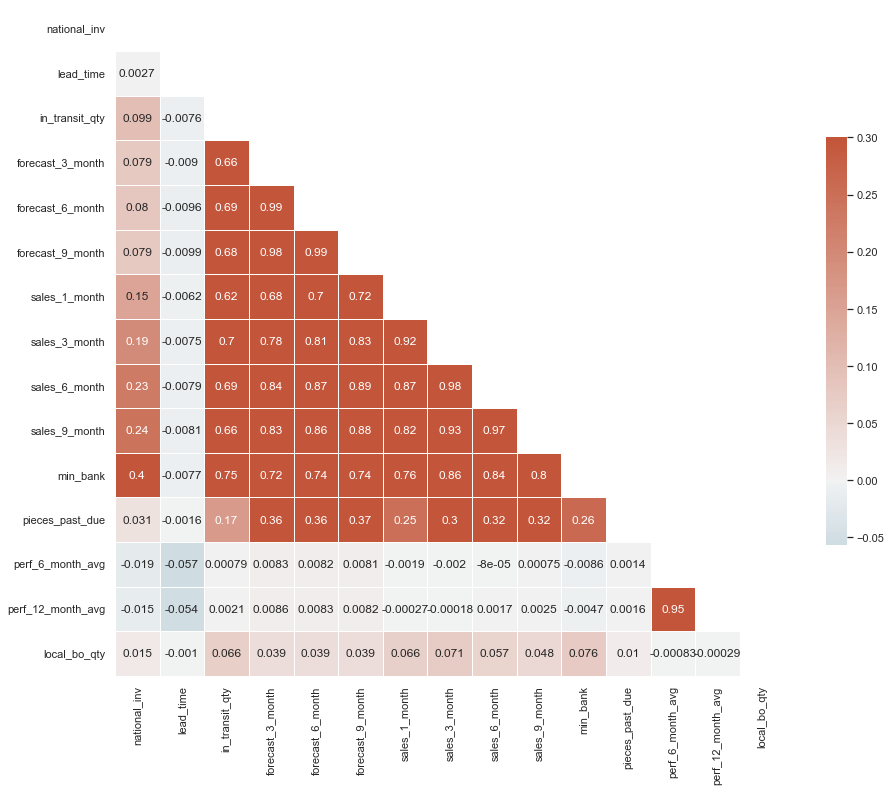

In [27]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

#### Observations:

1. All features are observed with positive correlations, which mean a feature simply contributes to other feature values.
2. forecast_3_month, forecast_6_month and forecast_9_month are very strongly correlated with each other around to a degree of 0.90.
3. Similar to forecast features, sales features sale_1_month, sales_3_month, sales_6_month and sales_9_month are strongly correlated with each other with a degree ranging  from 0.82 to 0.98.
4. forecast and sale columns share a certain degree of correlations as it is obvious that when the sales for certain products are high in the prior sales, then the forecast for the same product in the future months will be higher and vice-versa.
5. the performance features perf_6_month_avg and perf_12_month_avg are very highly correlated with each other to a degree of 0.91.
6. min_bank feature which determine minimum recommended stock is highly correlated with sales and forecast columns as stock in inventory is directly proportional to sales.
7. in_transit_qty feature is having high correlation with sales, forecast, and min_bank columns, as it is logical because high sales of a product drive more than product in transport for inventory restocking, and high forecast of the product consider avoiding shortfall.
8. national_inv has a moderate correlation with min_bank with around 0.5 to 0.55 degrees and a weakly correlated with sale columns with less than 0.2 degrees.
9. As many features are correlated, few prominent features can easily be dropped for dimensional reduction and eliminate redundant information.

The highly correlated features with a threshold of 90 percent are forecast_6_month,  forecast_9_month, sales_3_month, 'sales_6_month, 'sales_9_month, perf_12_month_avg are dropped from the dataset.


## EDA

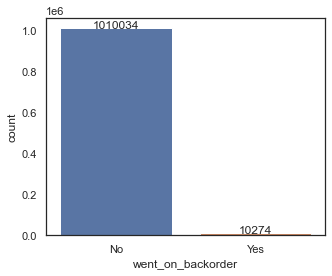

In [28]:
#sns.countplot(x='went_on_backorder', data=df)
fig, ax1 = plt.subplots(figsize=(5,4))
graph = sns.countplot(ax=ax1,x='went_on_backorder', data=train)
#graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        train['went_on_backorder'].value_counts()[i],ha="center")
    i += 1

In [29]:
round(10274/train.shape[0]*100,2)

1.01

In [30]:
occ = train['went_on_backorder'].value_counts()
ratio = occ/len(train.index)
print(f'The Ratio of backorder cases is:{ratio[1]}\nThe Ratio of non-backorder is:{ratio[0]}')

The Ratio of backorder cases is:0.010069508422946797
The Ratio of non-backorder is:0.9899304915770532


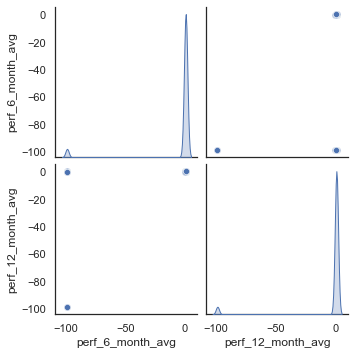

In [31]:
df_avg=train[['perf_6_month_avg','perf_12_month_avg']]
sns.pairplot(df_avg, diag_kind="kde")
fig.set_size_inches(15,8)
plt.show()

In [32]:
train['perf_12_month_avg']=train['perf_12_month_avg'].replace(-99, np.nan)
train['perf_6_month_avg']=train['perf_6_month_avg'].replace(-99, np.nan)

In [33]:
train['perf_12_month_avg'] = train['perf_12_month_avg'].fillna(train.perf_12_month_avg.median())
train['perf_6_month_avg'] = train['perf_6_month_avg'].fillna(train.perf_6_month_avg.median())

In [34]:
test['perf_12_month_avg']=test['perf_12_month_avg'].replace(-99, np.nan)
test['perf_6_month_avg']=test['perf_6_month_avg'].replace(-99, np.nan)

In [35]:
test['perf_12_month_avg'] = test['perf_12_month_avg'].fillna(test.perf_12_month_avg.median())
test['perf_6_month_avg'] = test['perf_6_month_avg'].fillna(test.perf_6_month_avg.median())

In [36]:
for col in train.columns:
    if train[col].dtypes=='O':
        print(col,'unique values',train[col].unique())        

potential_issue unique values ['No' 'Yes']
deck_risk unique values ['No' 'Yes']
oe_constraint unique values ['No' 'Yes']
ppap_risk unique values ['No' 'Yes']
stop_auto_buy unique values ['Yes' 'No']
rev_stop unique values ['No' 'Yes']
went_on_backorder unique values ['No' 'Yes']


In [37]:
train.describe(percentiles = [.25,.5,.75,.90,.95, .99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
national_inv,1020308.00000,729.18592,37741.29348,-27256.00000,9.00000,36.00000,154.00000,590.00000,1473.00000,8241.79000,12334404.00000
lead_time,1020308.00000,7.72256,7.04490,0.00000,4.00000,8.00000,8.00000,12.00000,12.00000,52.00000,52.00000
in_transit_qty,1020308.00000,72.65707,1726.37054,0.00000,0.00000,0.00000,4.00000,48.00000,146.00000,985.00000,489408.00000
forecast_3_month,1020308.00000,292.56632,6461.80956,0.00000,0.00000,0.00000,27.00000,216.00000,612.00000,3804.00000,1427612.00000
forecast_6_month,1020308.00000,568.04397,12592.86379,0.00000,0.00000,2.00000,63.00000,435.00000,1200.00000,7146.00000,2461360.00000
forecast_9_month,1020308.00000,834.61055,18486.11726,0.00000,0.00000,5.00000,100.00000,648.00000,1800.00000,10500.00000,3777304.00000
sales_1_month,1020308.00000,92.42715,2479.33065,0.00000,0.00000,2.00000,15.00000,80.00000,212.00000,1105.00000,741774.00000
sales_3_month,1020308.00000,289.22245,6675.87419,0.00000,1.00000,8.00000,50.00000,264.00000,682.00000,3542.00000,1105478.00000
sales_6_month,1020308.00000,564.58589,12359.20242,0.00000,3.00000,17.00000,103.00000,529.00000,1340.00000,6976.00000,2146625.00000
sales_9_month,1020308.00000,867.73759,19077.36076,0.00000,4.00000,26.00000,158.00000,803.00000,2034.00000,10563.79000,3205172.00000


#### Obervations ### 
Almost all numerical featues have a huge difference from 99 percentile and 100 percentile. Those are outlier.
We are considering only 99% records for this research and removing the outliers

Only negative value present in national_inv feature, so needs to validate if negative national_inv value have any relationship to backorder records.

### Data Visualization

In [38]:
#sns.displot(df_train.national_inv)

In [39]:
report = sweetviz.analyze(train, target_feat='went_on_backorder')

Done! Use 'show' commands to display/save.   |█████████████████████████████████████████| [100%]   00:01 -> (00:00 left)


In [40]:
report.show_html('report.html')

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [41]:
train

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.88000,0.87000,0.00000,No,No,No,Yes,No,No
1,2.00000,9.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.99000,0.99000,0.00000,No,No,No,Yes,No,No
2,2.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.88000,0.87000,0.00000,Yes,No,No,Yes,No,No
3,7.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.10000,0.13000,0.00000,No,No,No,Yes,No,No
4,8.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.00000,...,0.00000,0.88000,0.87000,0.00000,Yes,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020303,0.00000,2.00000,0.00000,10.00000,10.00000,10.00000,0.00000,5.00000,7.00000,7.00000,...,0.00000,0.69000,0.69000,5.00000,Yes,No,No,Yes,No,No
1020304,-1.00000,8.00000,0.00000,5.00000,7.00000,9.00000,1.00000,3.00000,3.00000,8.00000,...,0.00000,0.88000,0.87000,1.00000,No,No,No,Yes,No,No
1020305,-1.00000,9.00000,0.00000,7.00000,9.00000,11.00000,0.00000,8.00000,11.00000,12.00000,...,0.00000,0.86000,0.84000,1.00000,Yes,No,No,No,No,Yes
1020306,62.00000,9.00000,16.00000,39.00000,87.00000,126.00000,35.00000,63.00000,153.00000,205.00000,...,0.00000,0.86000,0.84000,6.00000,No,No,No,Yes,No,No


In [42]:
def plot_distribution(data_select) : 
    figsize =( 15, 8)
    sns.set_style("ticks")
    s = sns.FacetGrid(train, hue = 'went_on_backorder',aspect = 2.5, palette ={'No' : 'lime', 'Yes' :'black'})
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.6)
    s.set(xlim=(train[data_select].min(), train[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

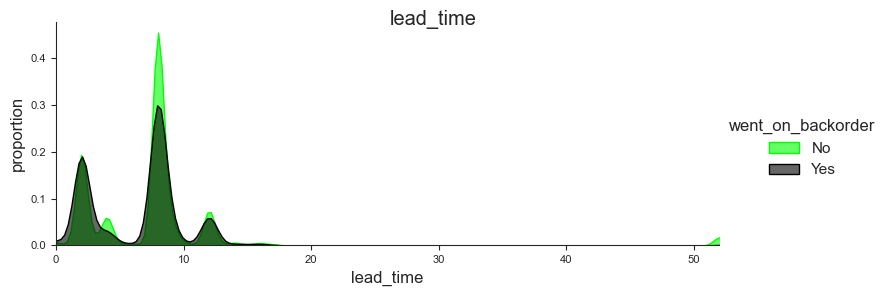

In [43]:
plot_distribution('lead_time')

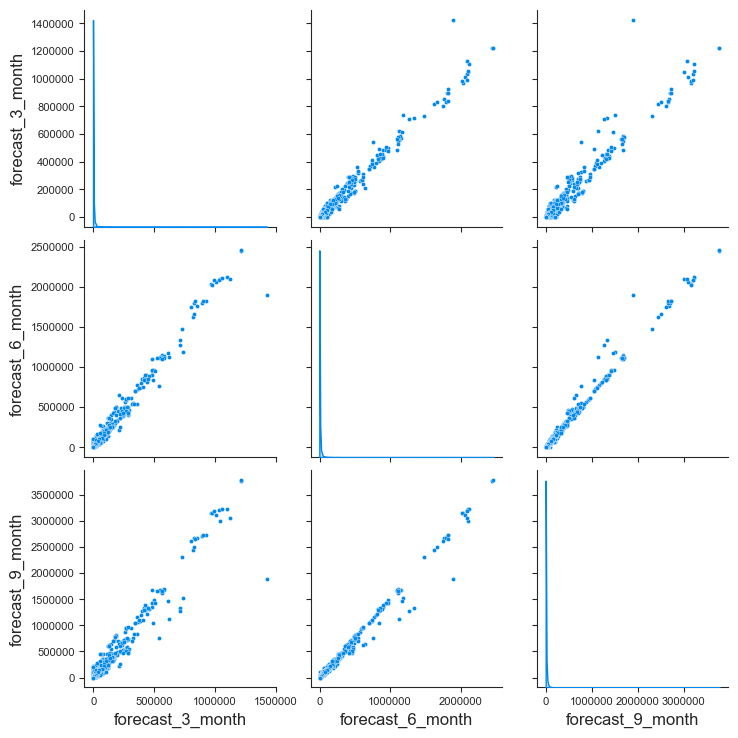

In [44]:
forcast=train[['forecast_3_month','forecast_6_month', 'forecast_9_month']]
sns.pairplot(forcast, diag_kind="kde")
fig.set_size_inches(15,8)
plt.show()

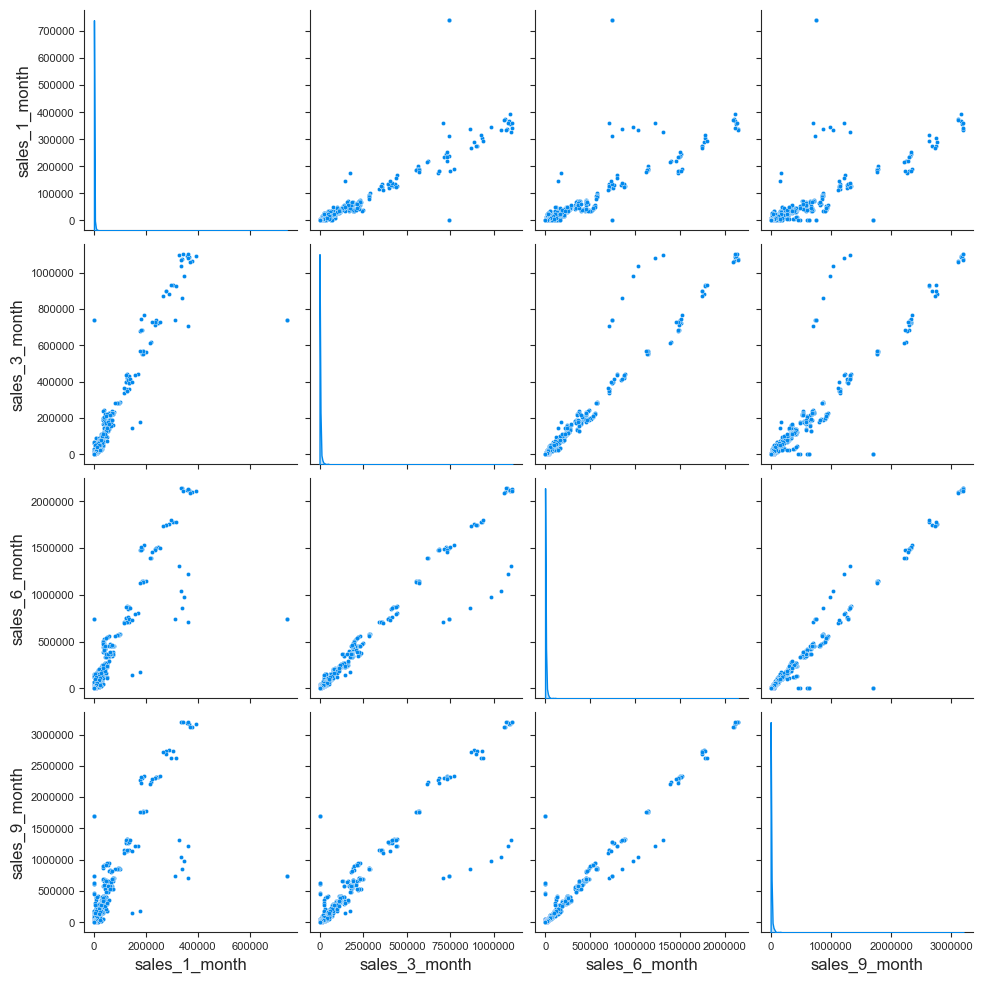

In [45]:
sale=train[['sales_1_month','sales_3_month', 'sales_6_month', 'sales_9_month']]
sns.pairplot(sale, diag_kind="kde")
fig.set_size_inches(15,8)
plt.show()

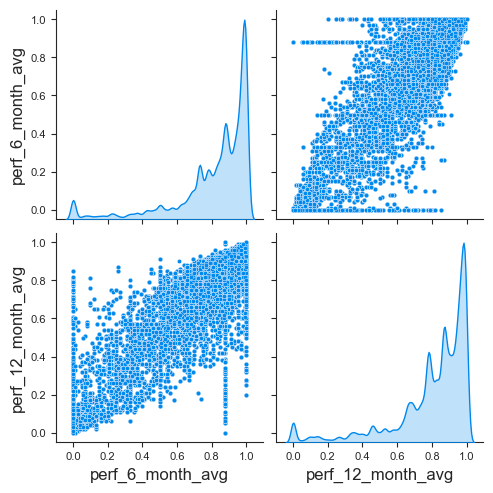

In [46]:
df_avg=train[['perf_6_month_avg','perf_12_month_avg']]
sns.pairplot(df_avg, diag_kind="kde")
fig.set_size_inches(15,8)
plt.show()

In [47]:
### Let check outliers of all the features

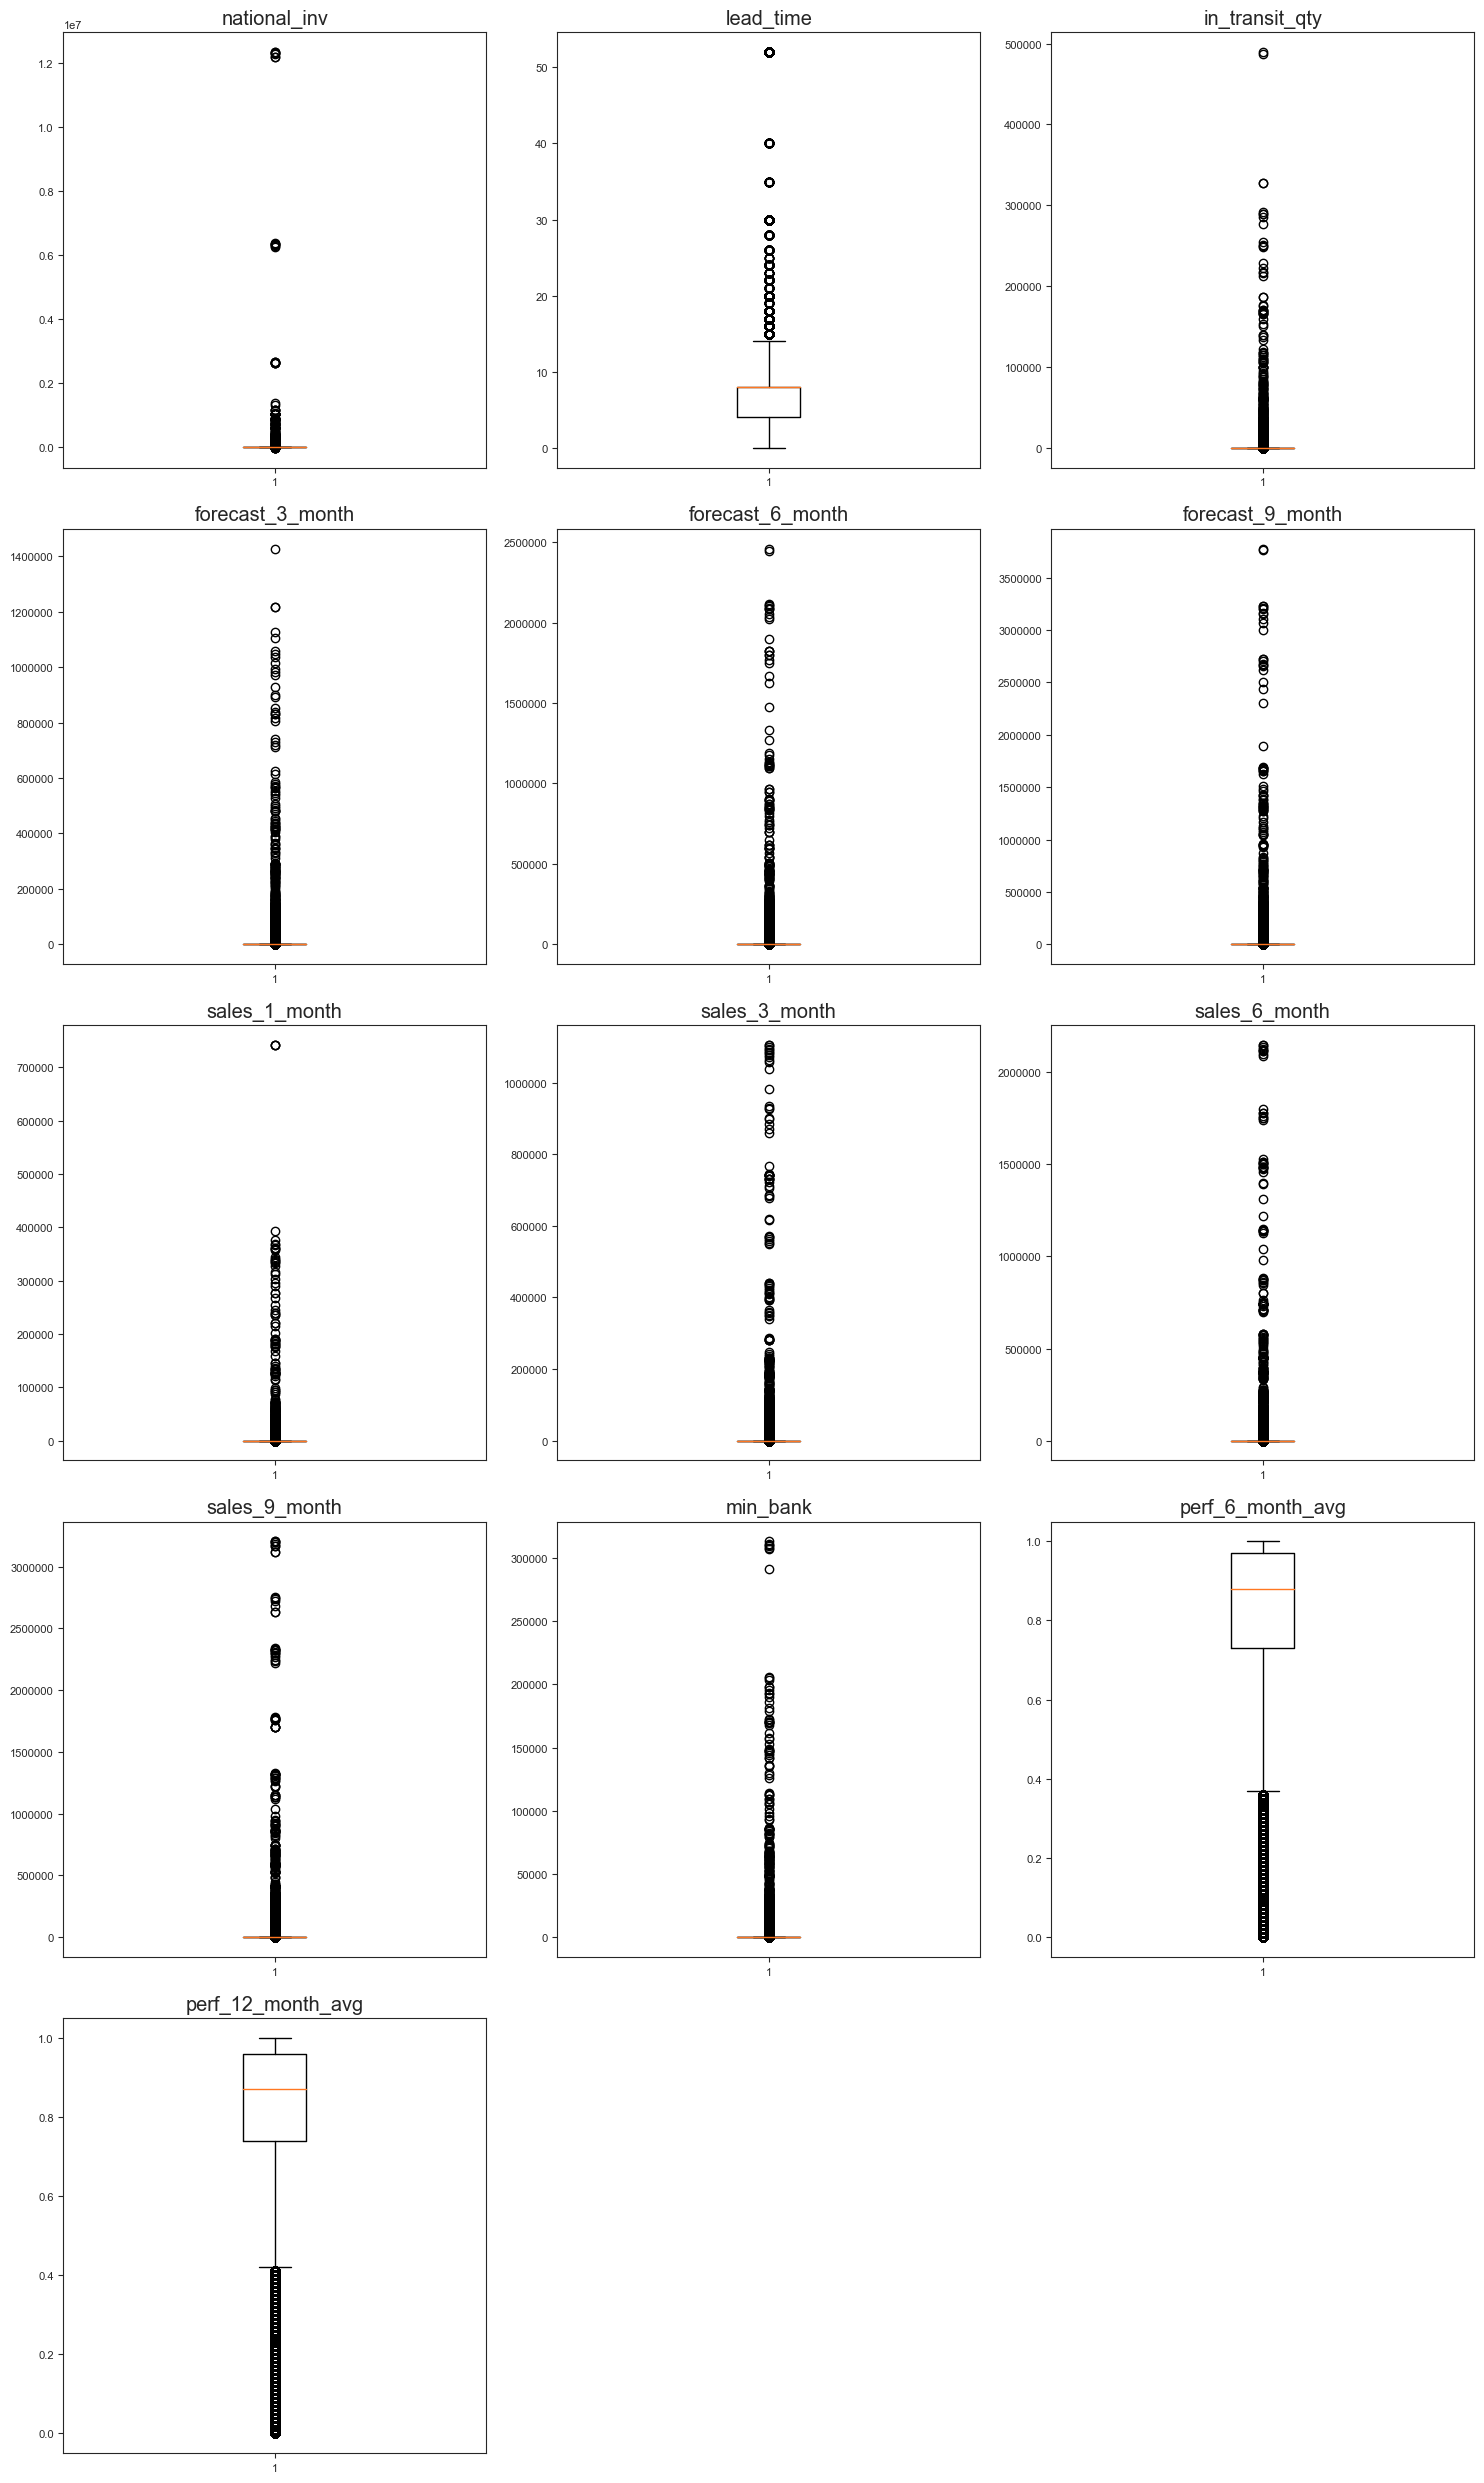

In [48]:
import math

# boxplot of each numerical feature
numerical_cols = train.select_dtypes('number').columns.drop(['local_bo_qty','pieces_past_due'])
rows = math.ceil(len(numerical_cols)/3)
cols = 3
plot_index = 1
plt.figure(figsize=(15,25))
for col in numerical_cols:
    plt.subplot(rows,cols,plot_index)
    plt.boxplot(train[col])
    plt.title(col)
    
    plot_index+=1
    
plt.tight_layout()
plt.show();

In [49]:
### ALl features except performance 6 and 12 months average are highly right skewed. 

In [50]:
def displot(column):
    '''plots density plot, cdf, histogram and boxplot for a given column value'''
    
    fig,ax = plt.subplots(2,2,figsize = (10,8))
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    sns.kdeplot(data = train,x = column,color='darkgreen',ax = ax[0,0]);
    ax[0,0].set_title(column.upper() + ' Density plot',)
    
    sns.ecdfplot(train[column],color = 'orange',ax = ax[0,1])
    ax[0,1].set_title(column.upper() + ' Cumulative Distribution plot',)
    
    sns.histplot(train[column],bins=15,ax = ax[1,0])
    ax[1,0].set_title(column.upper() + ' Histogram')
    
    sns.boxplot(train[column],ax = ax[1,1])
    ax[1,1].set_title(column.upper() + ' Boxplot')
    plt.tight_layout()
    
    fig.suptitle('Distribution plots of '+ column.upper(),fontsize = 'x-large',color = 'darkolivegreen',y=1.1)
    plt.show();

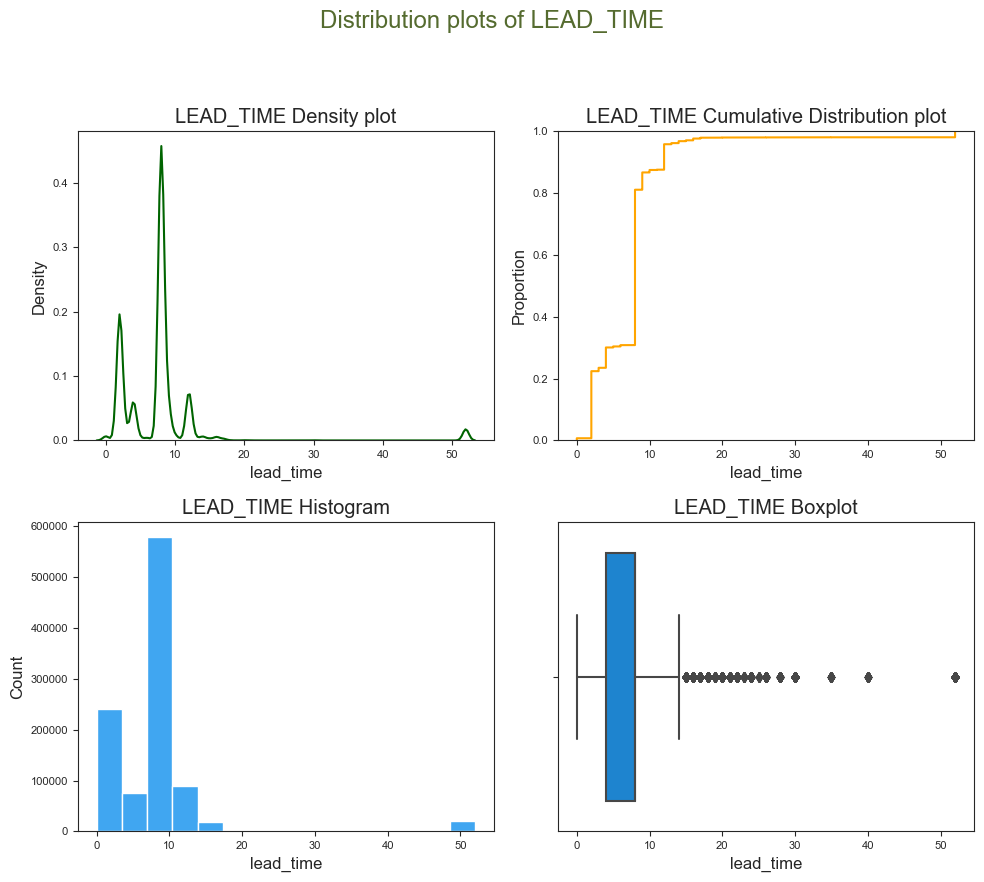

In [51]:
displot('lead_time')

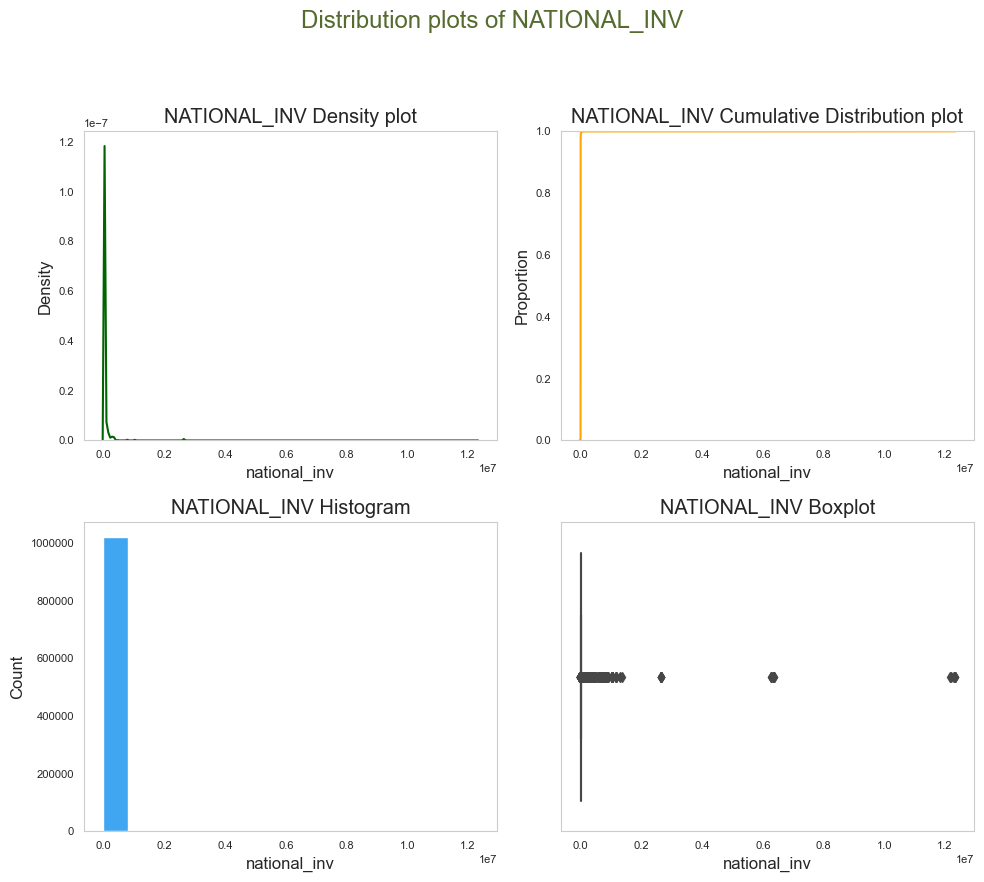

In [52]:
displot('national_inv')

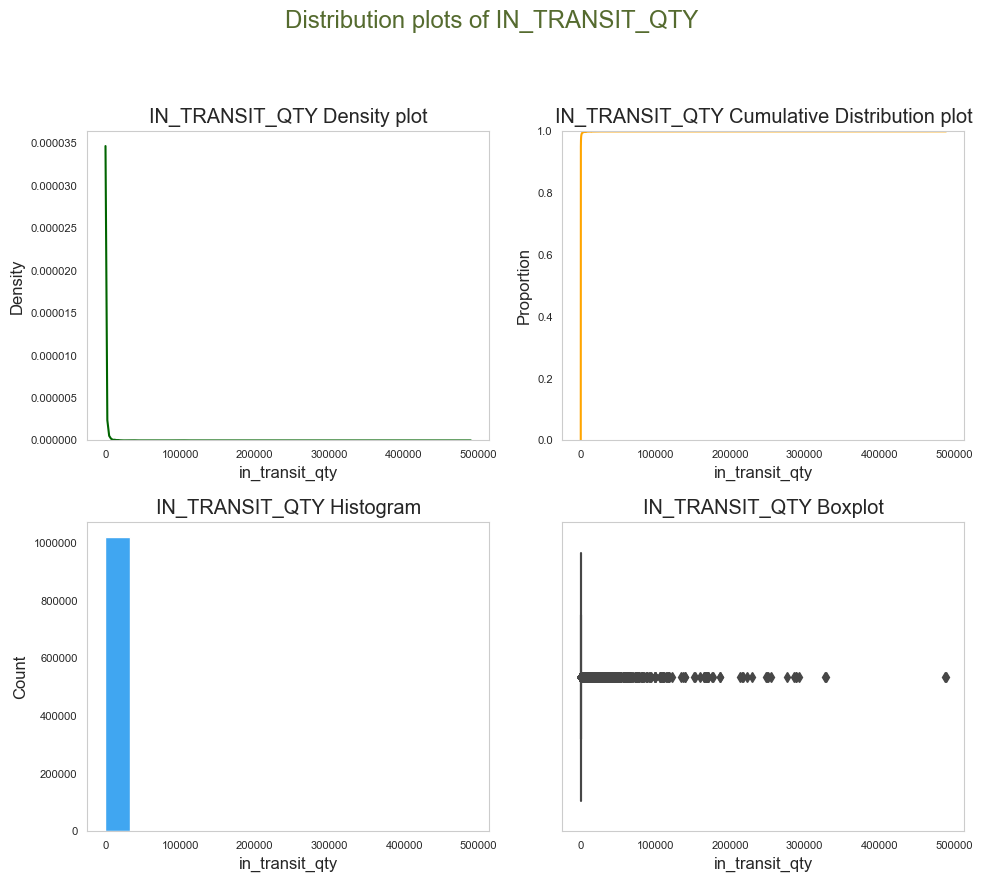

In [53]:
displot('in_transit_qty')

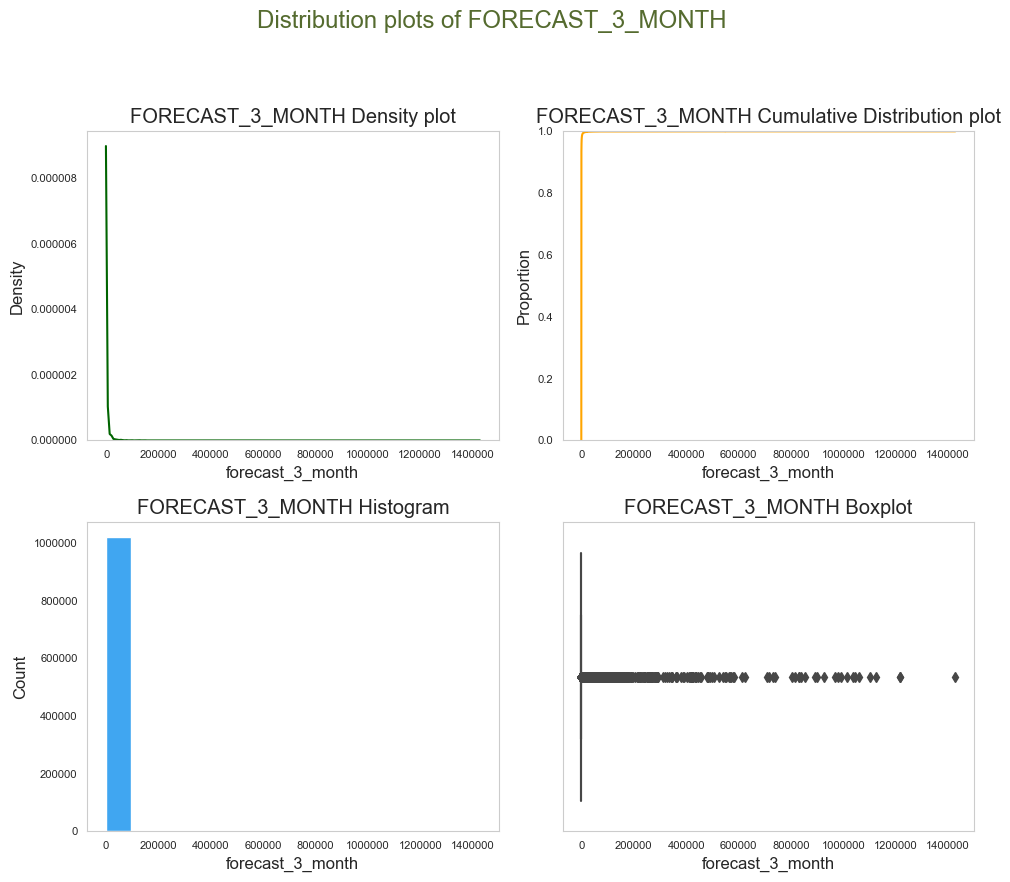

In [54]:
displot('forecast_3_month')

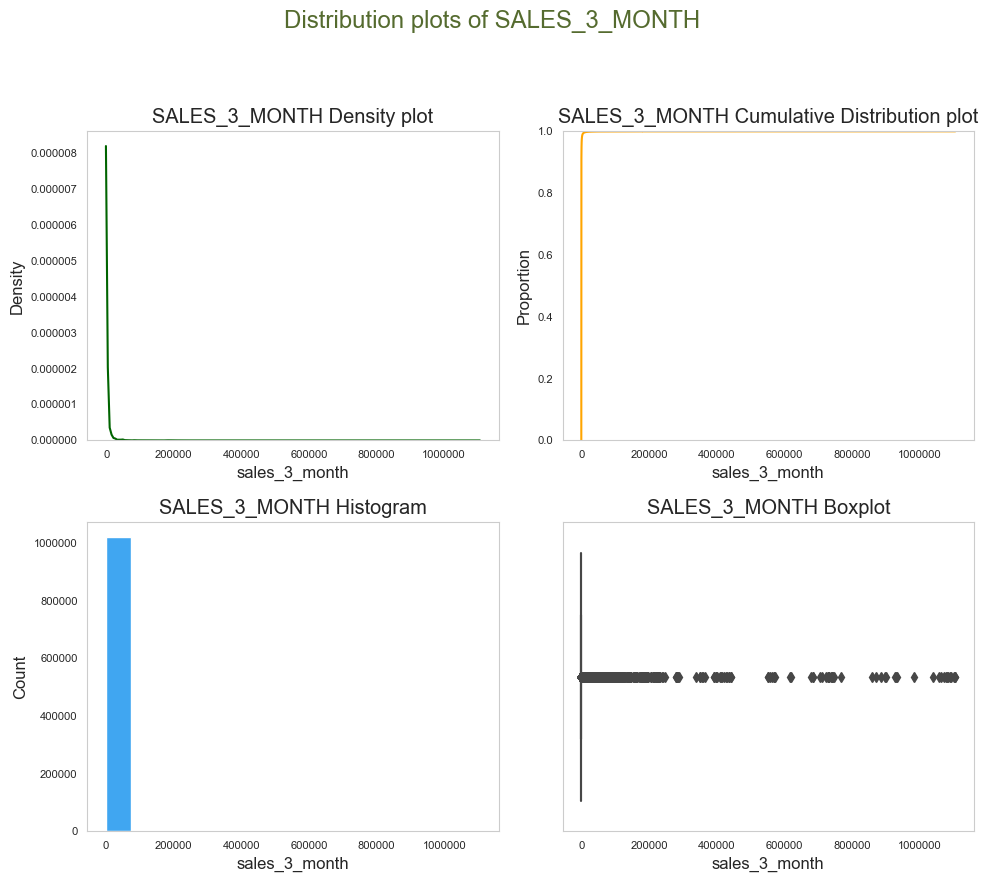

In [55]:
displot('sales_3_month')

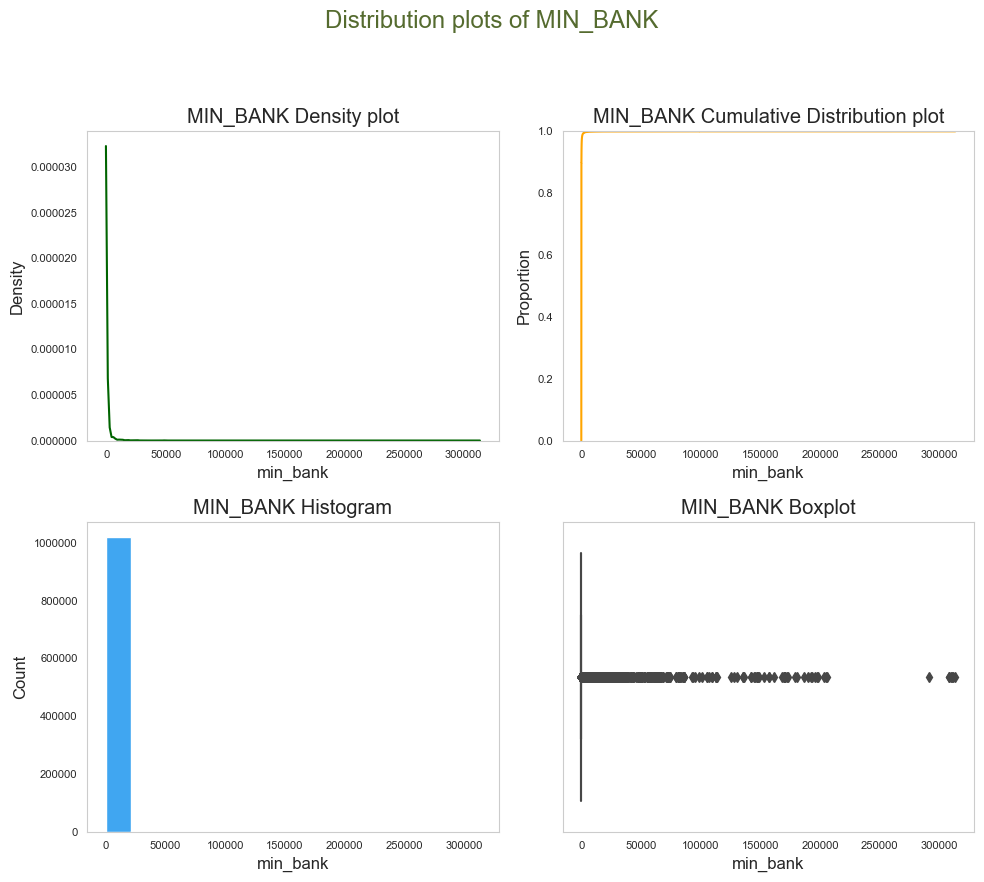

In [56]:
displot('min_bank')

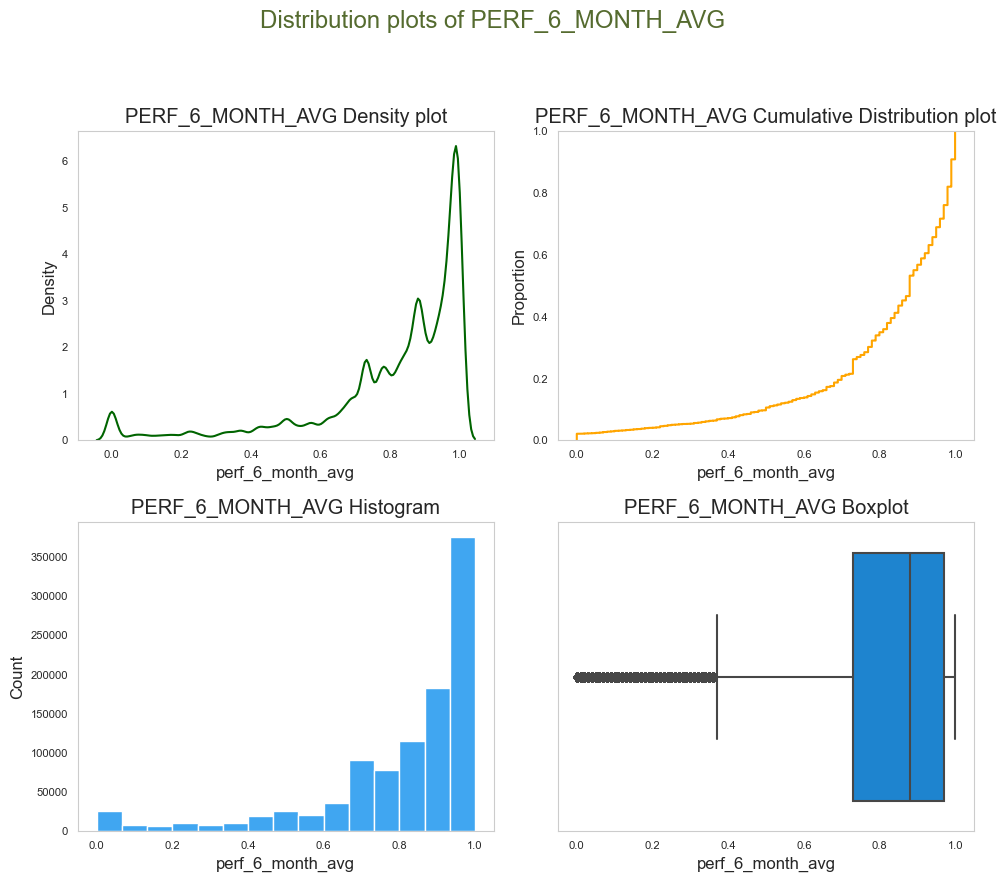

In [57]:
displot('perf_6_month_avg')

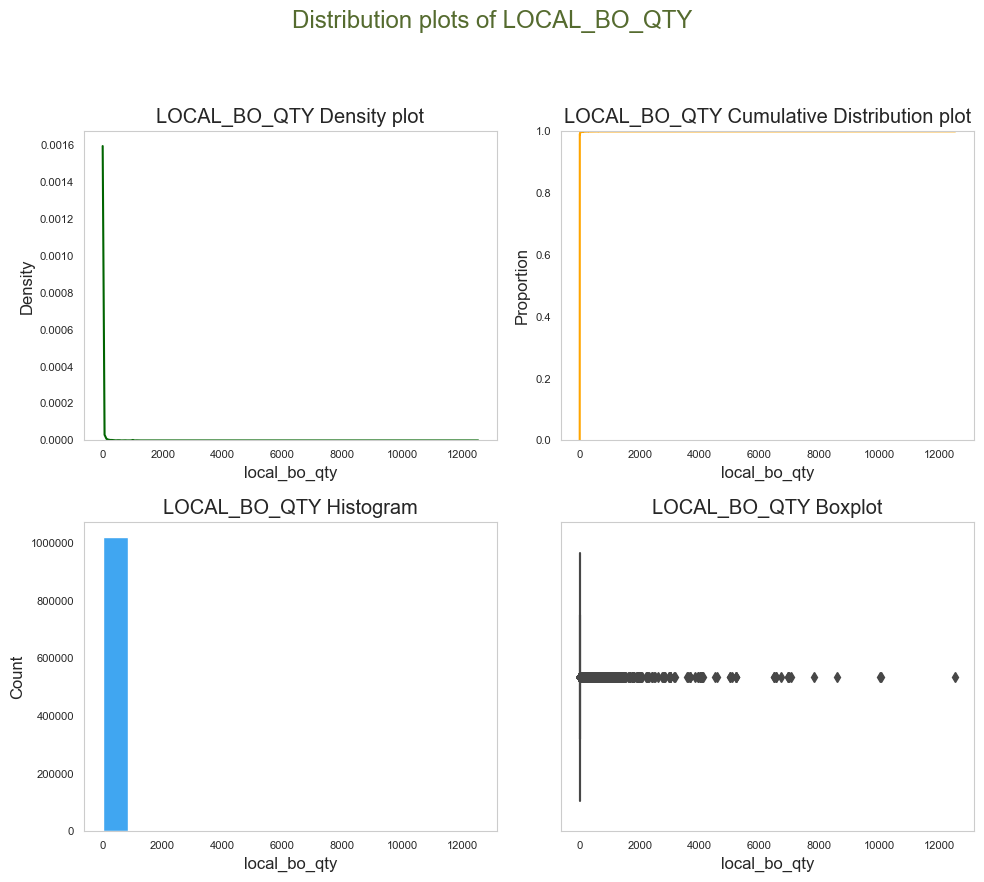

In [58]:
displot('local_bo_qty')

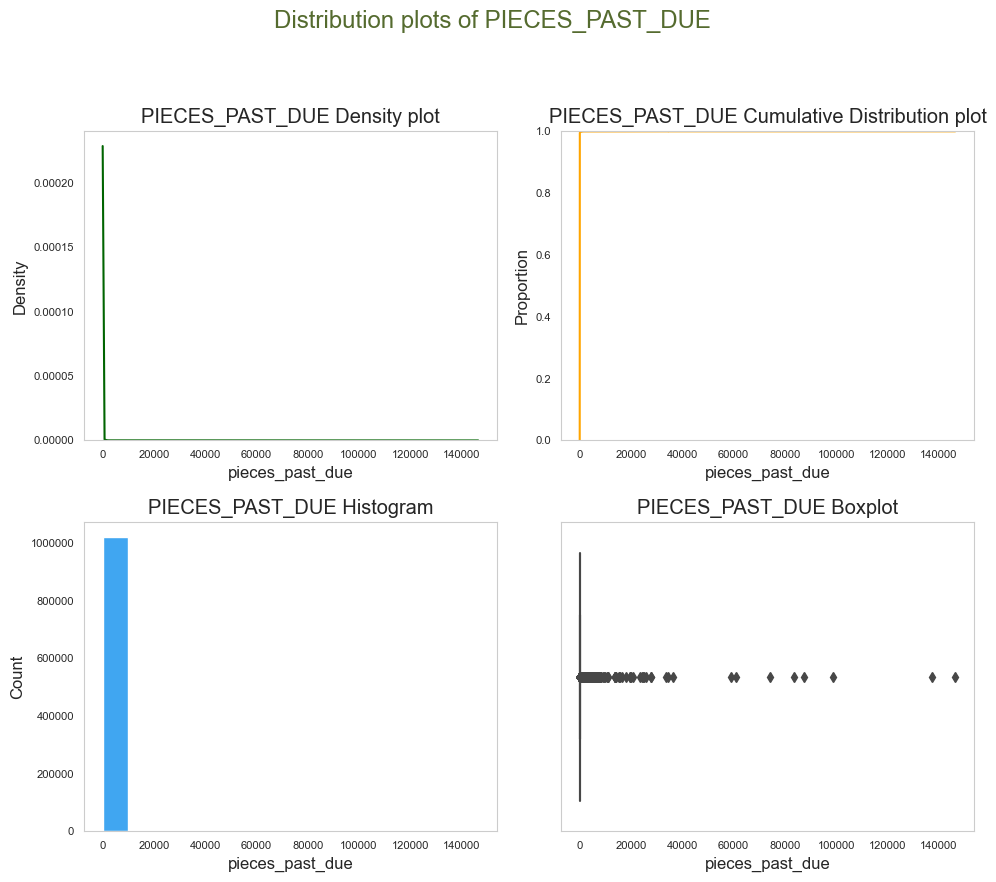

In [59]:
displot('pieces_past_due')

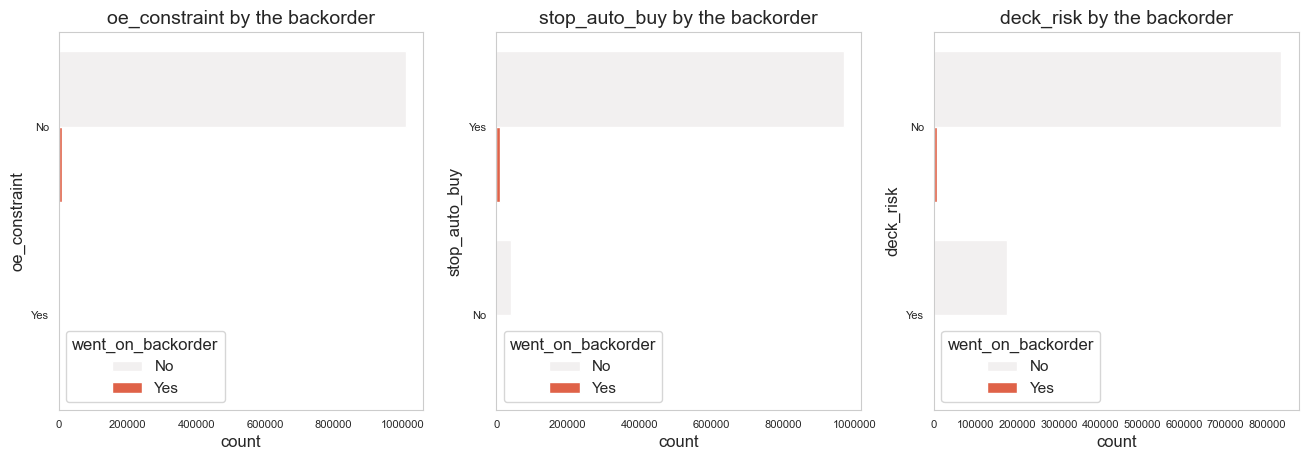

In [60]:

fig, ax = plt.subplots(1, 3, figsize=(16,5))
sns.countplot(y ='oe_constraint', hue = "went_on_backorder", data = train, color="#F8522F", ax=ax[0])
ax[0].set_title("oe_constraint by the backorder", fontsize=14)

sns.countplot(y='stop_auto_buy', hue = "went_on_backorder", data = train, color="#F8522F", ax=ax[1])
ax[1].set_title("stop_auto_buy by the backorder", fontsize=14)

sns.countplot(y ='deck_risk', hue = "went_on_backorder", data = train, color="#F8522F", ax=ax[2])
ax[2].set_title("deck_risk by the backorder", fontsize=14)

plt.show()

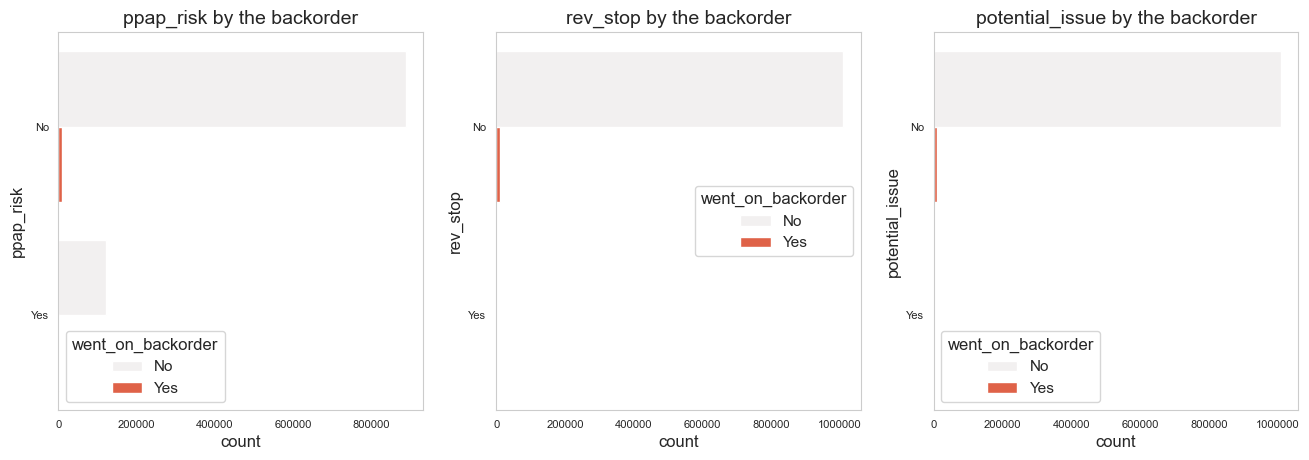

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))
sns.countplot(y='ppap_risk', hue = "went_on_backorder", data = train, color="#F8522F", ax=ax[0])
ax[0].set_title("ppap_risk by the backorder", fontsize=14)

sns.countplot(y='rev_stop', hue = "went_on_backorder", data = train, color="#F8522F", ax=ax[1])
ax[1].set_title("rev_stop by the backorder", fontsize=14)

sns.countplot(y='potential_issue', hue = "went_on_backorder", data = train, color="#F8522F", ax=ax[2])
ax[2].set_title("potential_issue by the backorder", fontsize=14)

plt.show()

### Non of categorical variable pays crucial roles in presenting an observation as Backorder or Non-Backorder

<AxesSubplot:title={'center':'national_inv'}, xlabel='went_on_backorder'>

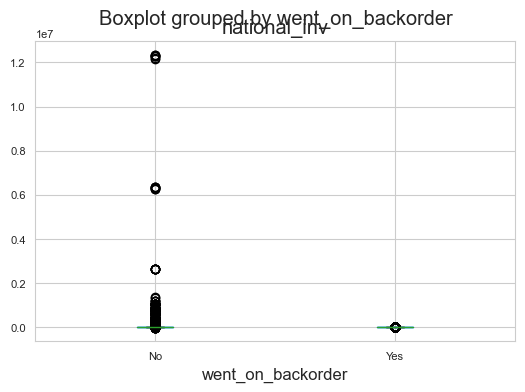

In [62]:
train.boxplot(column=['national_inv'], by='went_on_backorder')

In [63]:
train[train['went_on_backorder']=="Yes"].national_inv.min()

-2999.0

In [64]:
train[train['went_on_backorder']=="Yes"].national_inv.max()

29332.0

In [65]:
train['went_on_backorder'].value_counts()

No     1010034
Yes      10274
Name: went_on_backorder, dtype: int64

<AxesSubplot:xlabel='lead_time', ylabel='national_inv'>

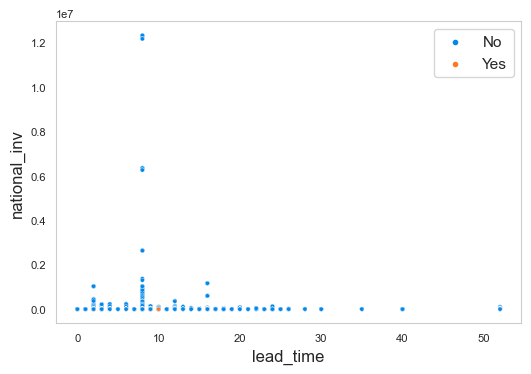

In [66]:
sns.scatterplot(x='lead_time', y='national_inv', hue=train.went_on_backorder.to_list(), data=train)

### Visualize lead_time with other features and only backorder records

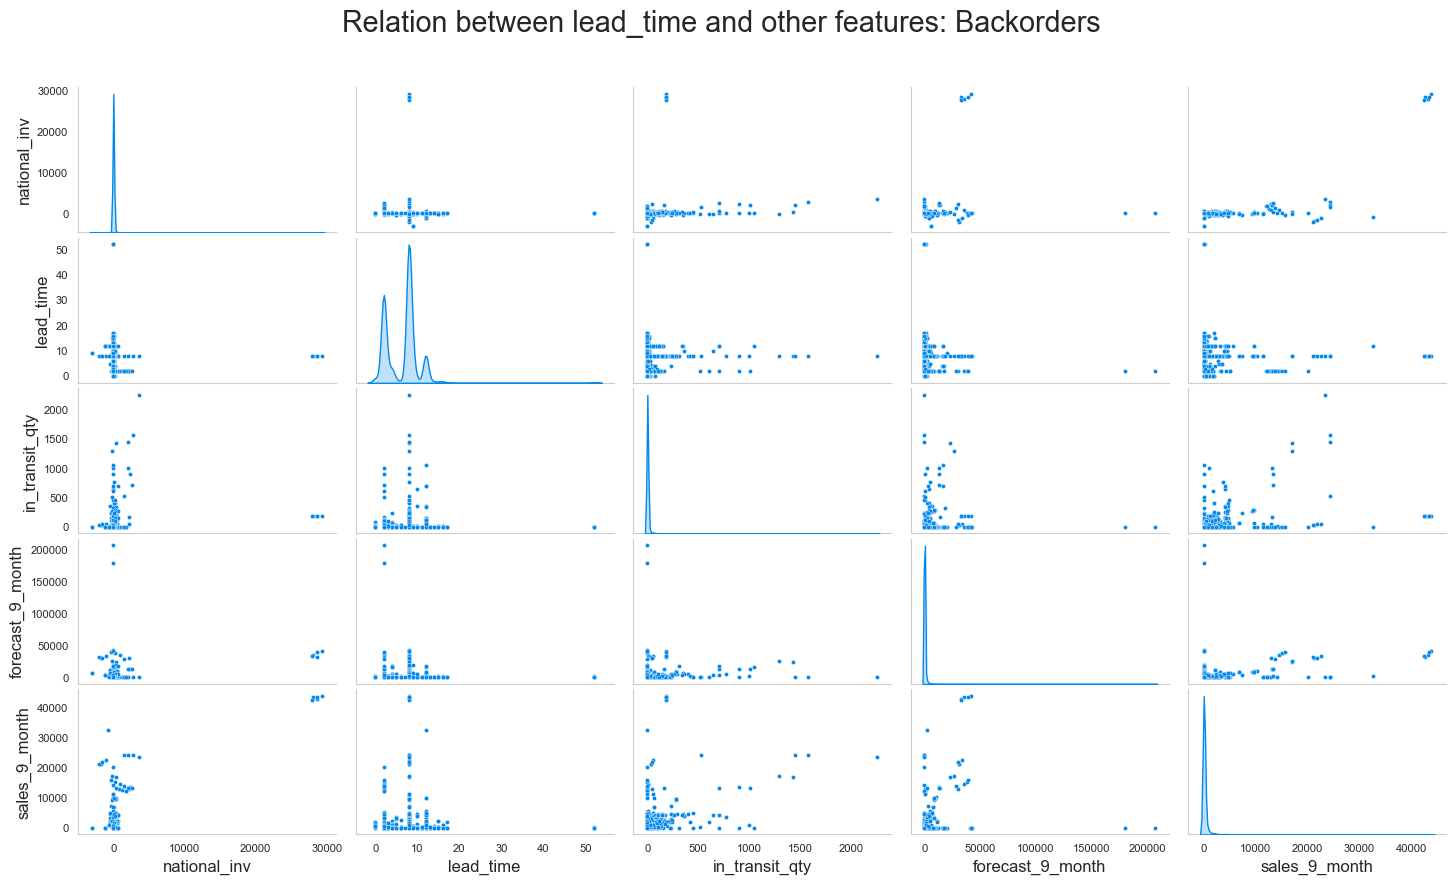

In [67]:
g = sns.pairplot(train[train['went_on_backorder'] == 'Yes'][['national_inv','lead_time','in_transit_qty','forecast_9_month','sales_9_month']],diag_kind='kde',);
g.fig.set_size_inches(15,8)
g.fig.suptitle("Relation between lead_time and other features: Backorders", y=1.08,fontsize = 'xx-large');

In [68]:
def valdiate_feature_imp(cols):
    
    for column in cols:
        X_train, X_test,y_train,y_test = train_test_split(train[column],train['went_on_backorder'], test_size =0.3, stratify=train['went_on_backorder'])
 
        X_train = X_train.values.reshape(-1,1)
        clf = LogisticRegression(random_state=0)
        clf.fit(X_train, y_train.values.reshape(-1,1))

        pred_proba = clf.predict_proba(X_test.values.reshape(-1,1))

        fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
        precision_train, recall_train, _ = precision_recall_curve(y_test, pred_proba[:,1])
        print('for i = ',column)
        print('-'*20)
        print('AUC:: ',round(metrics.auc(fpr, tpr),3))
        print('PR-AUC score ::',round(auc(recall_train, precision_train),3),'\n')

#### Categorical to numerical

In [69]:
for col in train.columns:
    
    if train[col].dtypes=='O':
        train[col]=train[col].map({'No': 0, 'Yes' :1}).astype(int)
        
for col in test.columns:

    if test[col].dtypes=='O':
        test[col]=test[col].map({'No': 0, 'Yes' :1}).astype(int)        

In [70]:
for column in ['deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop','potential_issue']:
    X_train, X_test,y_train,y_test = train_test_split(train[column],train['went_on_backorder'], test_size =0.3, stratify=train['went_on_backorder'])
 
    X_train = X_train.values.reshape(-1,1)
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train.values.reshape(-1,1))

    pred_proba = clf.predict_proba(X_test.values.reshape(-1,1))

    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
    precision_train, recall_train, _ = precision_recall_curve(y_test, pred_proba[:,1])
    print('for i = ',column)
    print('-'*20)
    print('AUC:: ',round(metrics.auc(fpr, tpr),3))
    print('PR-AUC score ::',round(auc(recall_train, precision_train),3),'\n')
    

NameError: name 'LogisticRegression' is not defined

In [ ]:
train[train.lead_time<20]['went_on_backorder'].value_counts()

#### The backorder observations having lead_time less than 20

#### National_inv

<AxesSubplot:xlabel='national_inv', ylabel='went_on_backorder'>

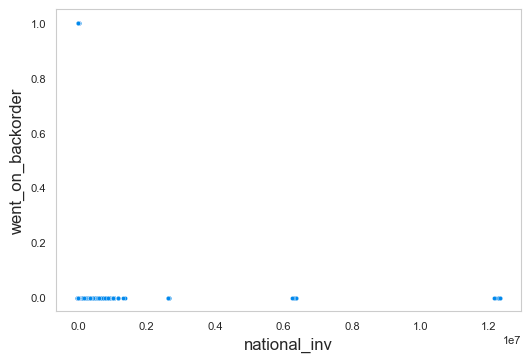

In [71]:
sns.scatterplot(x='national_inv', y='went_on_backorder', data=train)

In [73]:
train[train['national_inv'] == 0]['went_on_backorder'].value_counts()


0    36228
1     3293
Name: went_on_backorder, dtype: int64

In [74]:
train[train['national_inv'] <= 0]['went_on_backorder'].value_counts()

0    40929
1     4158
Name: went_on_backorder, dtype: int64

#### Around 4000 backorder observations having national_inv 0, which can be key fact or to decide if product are backorder or not

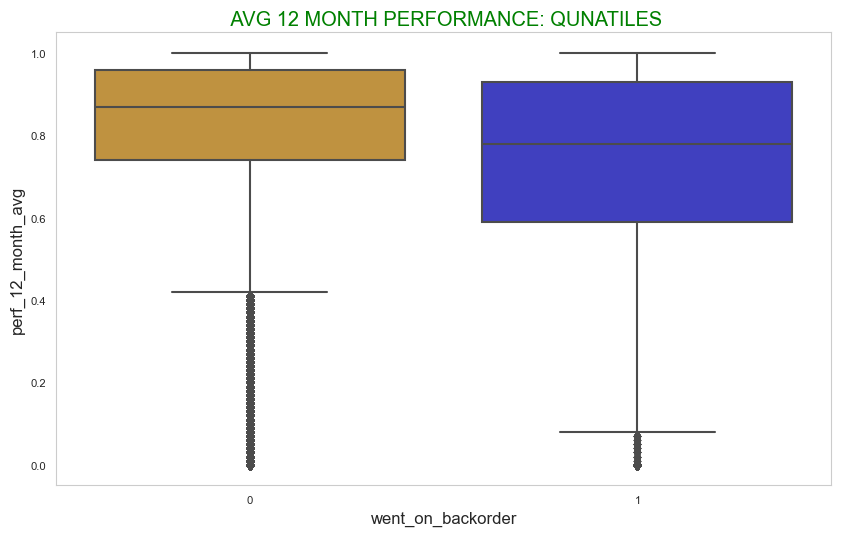

In [75]:
plt.figure(figsize=(10,6))
sns.boxplot(data = train,x = 'went_on_backorder',y = 'perf_12_month_avg',palette = ['orange','blue'],saturation=0.5,);
plt.title(' avg 12 month performance: Qunatiles'.upper(),color='green');

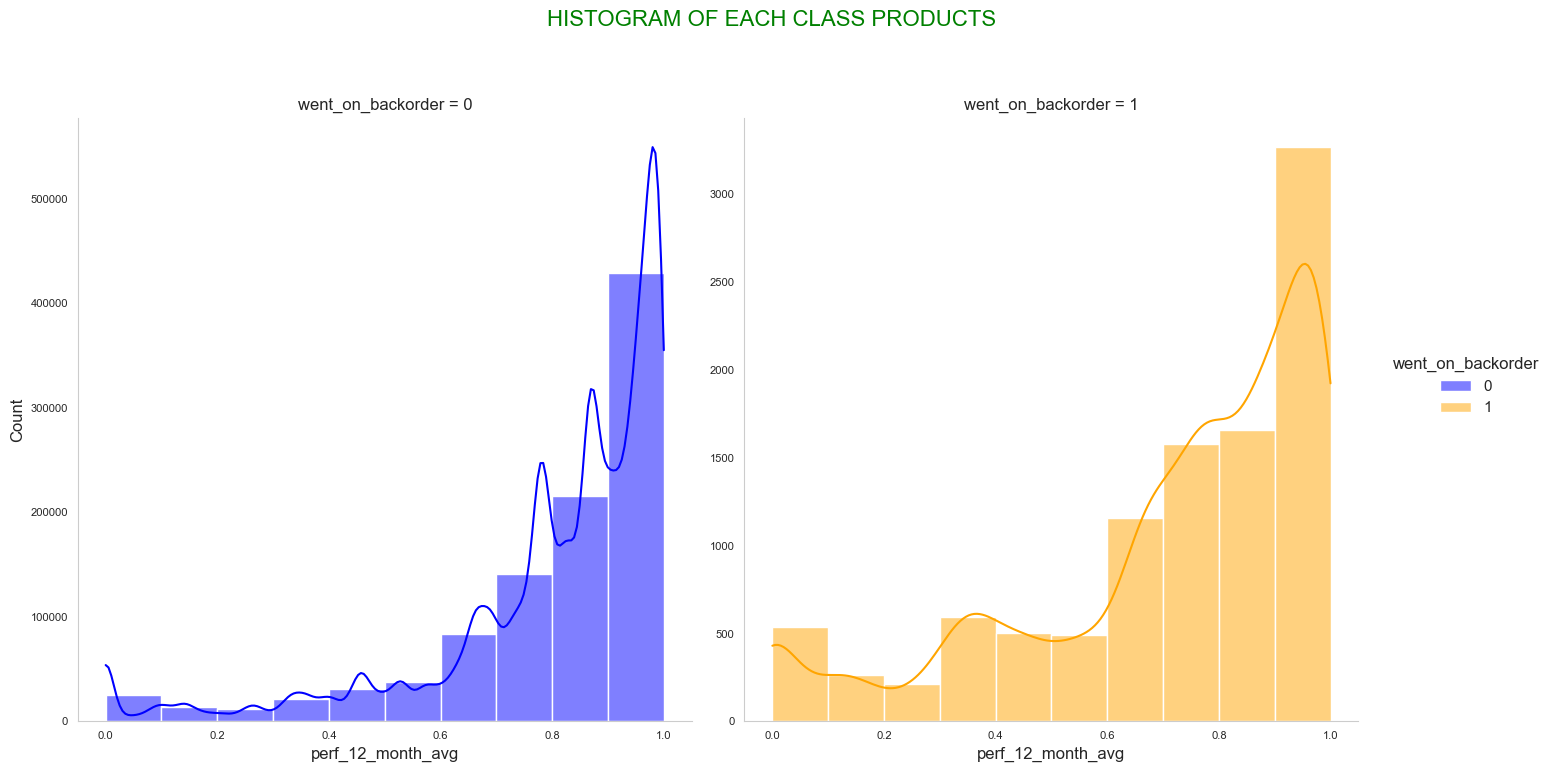

In [76]:
plt.close()
#plt.figure(figsize=(14,8))
sns.displot(data = train,x = 'perf_12_month_avg',col = 'went_on_backorder',hue = 'went_on_backorder',bins = 10,facet_kws={'sharey': False},palette = ['blue','orange'],height=7,aspect=1,kde=True)
plt.suptitle('Histogram of each class products'.upper(),color = 'green',fontsize=16,y=1.1)
plt.show()

#### Removing outliers

In [77]:
train = pd.read_csv("Backorder_Training_Dataset.csv")
test = pd.read_csv("Backorder_Test_Dataset.csv")

train.drop(index=train.shape[0]-1, axis=0, inplace=True)
test.drop(index=test.shape[0]-1, axis=0, inplace=True)

train['lead_time'] = train['lead_time'].fillna(train.lead_time.median())
test['lead_time'] = test['lead_time'].fillna(test.lead_time.median())

train['perf_12_month_avg']=train['perf_12_month_avg'].replace(-99, np.nan)
train['perf_6_month_avg']=train['perf_6_month_avg'].replace(-99, np.nan)

train['perf_12_month_avg'] = train['perf_12_month_avg'].fillna(train.perf_12_month_avg.median())
train['perf_6_month_avg'] = train['perf_6_month_avg'].fillna(train.perf_6_month_avg.median())

test['perf_12_month_avg'] = test['perf_12_month_avg'].fillna(test.perf_12_month_avg.median())
test['perf_6_month_avg'] = test['perf_6_month_avg'].fillna(test.perf_6_month_avg.median())

train.drop(columns='sku', axis=-1, inplace=True)
test.drop(columns='sku', axis=-1, inplace=True)

#removing duplicate rows
print('No.of rows in dataframe before removing duplicates:',train.shape[0])
train.drop_duplicates(inplace = True)
print('No.of rows in dataframe after removing duplicates:',train.shape[0])

#removing duplicate rows
print('No.of rows in dataframe before removing duplicates:',test.shape[0])
test.drop_duplicates(inplace = True)
print('No.of rows in dataframe after removing duplicates:',test.shape[0])

No.of rows in dataframe before removing duplicates: 1687860
No.of rows in dataframe after removing duplicates: 1020037
No.of rows in dataframe before removing duplicates: 242075
No.of rows in dataframe after removing duplicates: 185366


In [78]:
train.shape

(1020037, 22)

In [79]:
Q1 = train.quantile(0.10)
Q3 = train.quantile(0.99)
IQR = Q3 - Q1

In [80]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ------------------------------------------------
def outlier_detect_normal(df, col):
    m = df[col].mean()
    s = df[col].std()
    return df[((df[col]-m)/s).abs()>3]

# ------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)
    print('outlier replace with upper bound - {}' .format(col)) 
    
# ------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)
    print('outlier replace with lower bound - {}' .format(col)) 

In [81]:
final_numeric_feature=['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
                       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due' ]

In [82]:
for i in range(len(final_numeric_feature)):
    print("IQR => {}: {}".format(final_numeric_feature[i],(outlier_detect(train[final_numeric_feature],final_numeric_feature[i]).shape[0])))
    print("Z_Score => {}: {}".format(final_numeric_feature[i],(outlier_detect_normal(train[final_numeric_feature],final_numeric_feature[i]).shape[0])))
    print("********************************")

IQR => national_inv: 3758
Z_Score => national_inv: 461
********************************
IQR => lead_time: 0
Z_Score => lead_time: 19970
********************************
IQR => in_transit_qty: 4177
Z_Score => in_transit_qty: 1787
********************************
IQR => forecast_3_month: 4168
Z_Score => forecast_3_month: 1935
********************************
IQR => forecast_6_month: 4315
Z_Score => forecast_6_month: 1793
********************************
IQR => forecast_9_month: 4266
Z_Score => forecast_9_month: 1759
********************************
IQR => sales_1_month: 3967
Z_Score => sales_1_month: 1276
********************************
IQR => sales_3_month: 3931
Z_Score => sales_3_month: 1442
********************************
IQR => sales_6_month: 3879
Z_Score => sales_6_month: 1562
********************************
IQR => sales_9_month: 3927
Z_Score => sales_9_month: 1546
********************************
IQR => min_bank: 3804
Z_Score => min_bank: 1980
********************************
IQ

In [83]:
outlier = []
for i in range(len(final_numeric_feature)):
    if outlier_detect(train[final_numeric_feature],final_numeric_feature[i]).shape[0] !=0:
        outlier.append(final_numeric_feature[i])

outlier

['national_inv',
 'in_transit_qty',
 'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'min_bank',
 'pieces_past_due']

In [84]:
for i in range(len(outlier)):
    replace_upper(train, outlier[i]) 
    
print("\n**************************************\n")
for i in range(len(outlier)):
    replace_lower(train, outlier[i])

outlier replace with upper bound - national_inv
outlier replace with upper bound - in_transit_qty
outlier replace with upper bound - forecast_3_month
outlier replace with upper bound - forecast_6_month
outlier replace with upper bound - forecast_9_month
outlier replace with upper bound - sales_1_month
outlier replace with upper bound - sales_3_month
outlier replace with upper bound - sales_6_month
outlier replace with upper bound - sales_9_month
outlier replace with upper bound - min_bank
outlier replace with upper bound - pieces_past_due

**************************************

outlier replace with lower bound - national_inv
outlier replace with lower bound - in_transit_qty
outlier replace with lower bound - forecast_3_month
outlier replace with lower bound - forecast_6_month
outlier replace with lower bound - forecast_9_month
outlier replace with lower bound - sales_1_month
outlier replace with lower bound - sales_3_month
outlier replace with lower bound - sales_6_month
outlier repla

In [85]:
train.shape

(1020037, 22)

In [86]:
train.describe(percentiles = [.10,.25,.30,.40,.5,.60,.75,.90,.95, .98, .99]).T

,count,mean,std,min,10%,25%,30%,40%,50%,60%,75%,90%,95%,98%,99%,max
national_inv,1020037.00000,404.71945,1758.65455,-12359.46000,3.00000,9.00000,11.00000,20.00000,36.00000,64.00000,155.00000,590.00000,1474.00000,4420.00000,8244.64000,20607.10000
lead_time,1020037.00000,7.72250,7.04582,0.00000,2.00000,4.00000,4.00000,8.00000,8.00000,8.00000,8.00000,12.00000,12.00000,21.00000,52.00000,52.00000
in_transit_qty,1020037.00000,40.24647,212.14649,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.00000,48.00000,146.00000,462.00000,985.00000,2462.50000
forecast_3_month,1020037.00000,164.12449,820.34568,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,27.00000,216.00000,612.00000,1873.00000,3804.64000,9511.60000
forecast_6_month,1020037.00000,317.55613,1553.51438,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,12.00000,63.00000,435.00000,1200.00000,3555.00000,7150.00000,17875.00000
forecast_9_month,1020037.00000,470.01426,2281.73329,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,20.00000,100.00000,648.00000,1800.00000,5196.00000,10500.00000,26250.00000
sales_1_month,1020037.00000,53.03291,238.60565,0.00000,0.00000,0.00000,0.00000,1.00000,2.00000,5.00000,15.00000,80.00000,212.00000,578.00000,1106.00000,2765.00000
sales_3_month,1020037.00000,171.57566,764.95541,0.00000,0.00000,1.00000,2.00000,4.00000,8.00000,16.00000,50.00000,265.00000,682.00000,1855.00000,3544.00000,8860.00000
sales_6_month,1020037.00000,339.33023,1501.69038,0.00000,0.00000,3.00000,4.00000,9.00000,17.00000,33.00000,103.00000,529.00000,1340.00000,3651.28000,6977.64000,17444.10000
sales_9_month,1020037.00000,515.31915,2277.04290,0.00000,0.00000,4.00000,7.00000,13.00000,26.00000,50.00000,158.00000,803.00000,2034.00000,5573.00000,10564.64000,26411.60000


In [ ]:
train

In [87]:
for col in ['deck_risk',
            'ppap_risk',
            'stop_auto_buy',
            'rev_stop',
            'oe_constraint',
            'potential_issue'
            'went_on_backorder']:    
    train[col]=pd.factorize(train[col])[0]

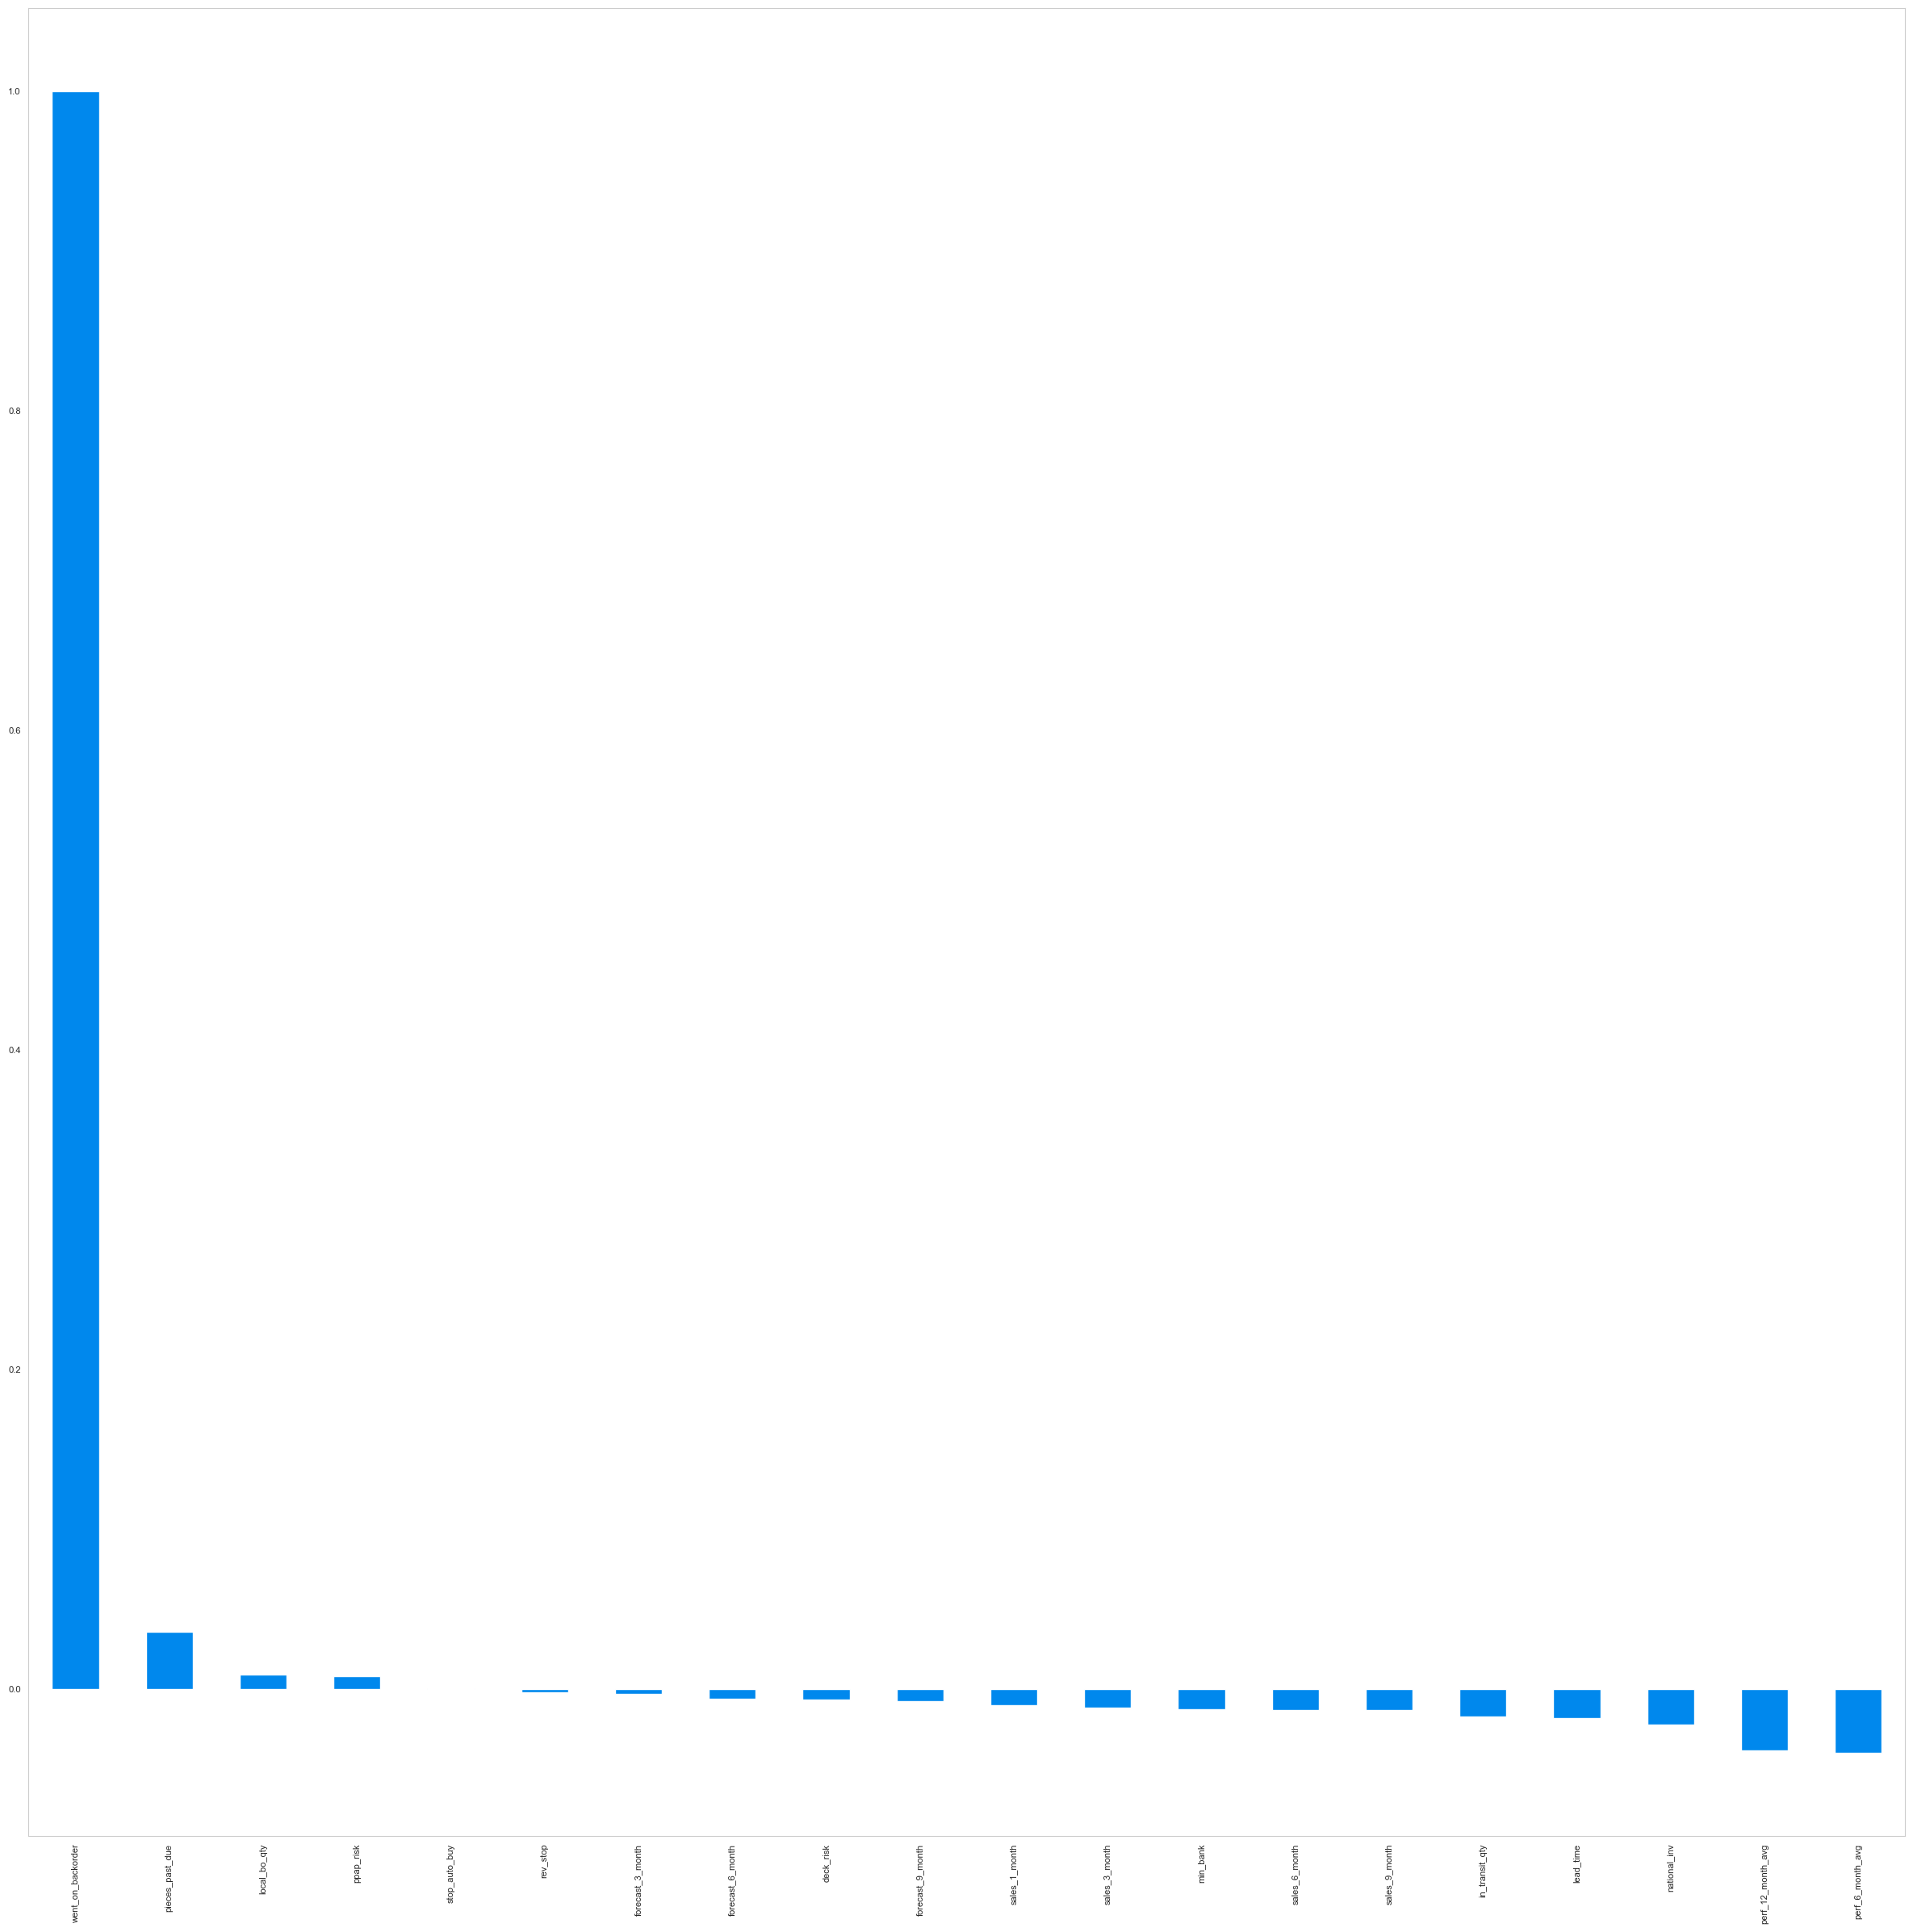

In [88]:
#Get Correlation of "went_on_backorder" with other variables:
plt.figure(figsize=(30,30))
train.corr()['went_on_backorder'].sort_values(ascending = False).plot(kind='bar')
plt.show()

In [89]:
train.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.85000,0.83000,0.00000,0,No,0,0,0,0
1,2.00000,9.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.99000,0.99000,0.00000,0,No,0,0,0,0
2,2.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.85000,0.83000,0.00000,1,No,0,0,0,0
3,7.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.10000,0.13000,0.00000,0,No,0,0,0,0
4,8.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.00000,...,0.00000,0.85000,0.83000,0.00000,1,No,0,0,0,0


### Memory Reduction

In [90]:
def bytesto(bytes, to, bsize=1024): 
    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(bytes)
    return bytes / (bsize ** a[to])

In [91]:
bytesto(train.memory_usage(deep=True).sum(),'m')

278.21696758270264

In [92]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [93]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 178.99 MB
Memory usage after optimization is: 62.26 MB
Decreased by 65.2%


In [94]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 32.53 MB
Memory usage after optimization is: 20.51 MB
Decreased by 37.0%


### Feature Engineering

##### Calculate Forecast and Sale difference and verify impact of backorder in differences

In [95]:
train['Forecast_Sale_Diff_3'] =  train['sales_3_month'] - train['forecast_3_month']
train['Forecast_Sale_Diff_6'] =  train['sales_6_month'] - train['forecast_6_month']
train['Forecast_Sale_Diff_9'] =  train['sales_9_month'] - train['forecast_9_month']

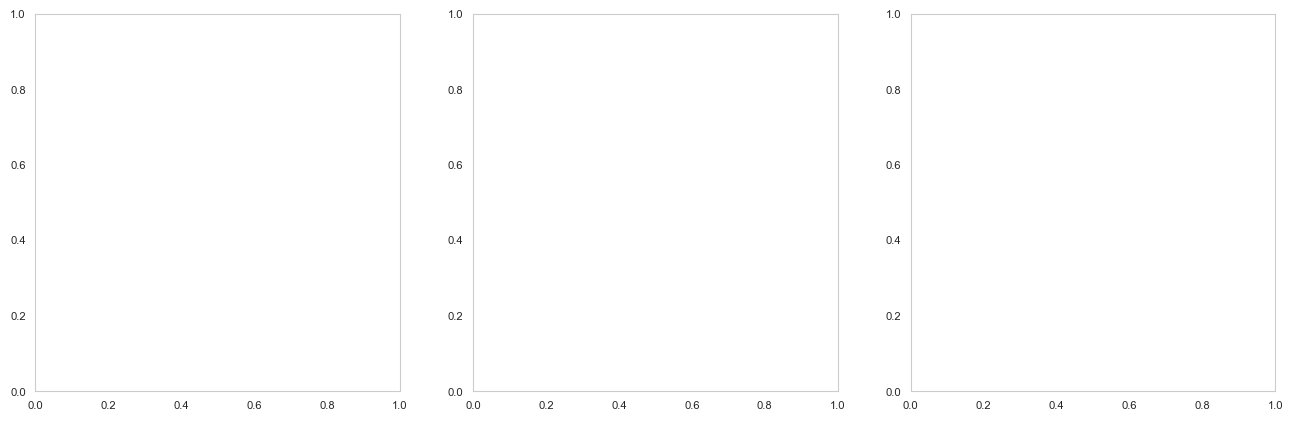

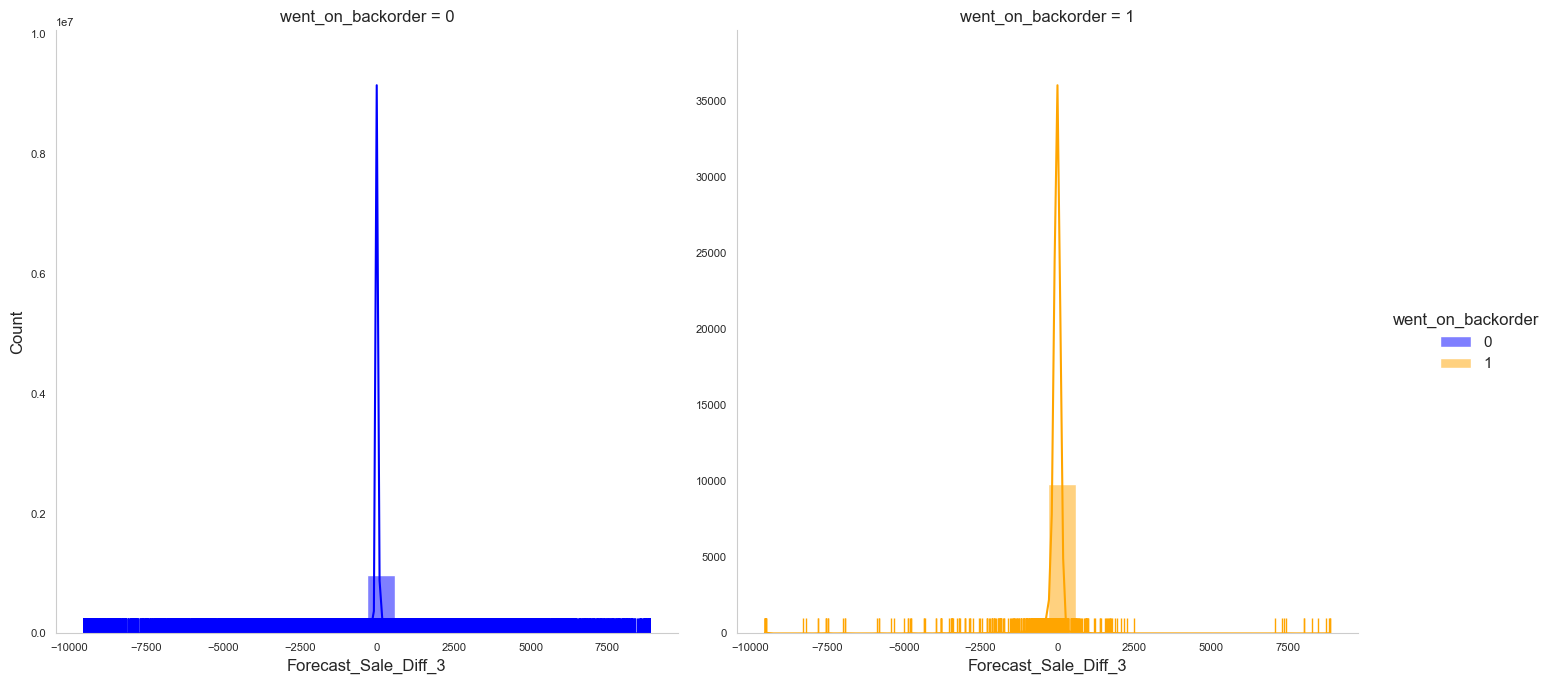

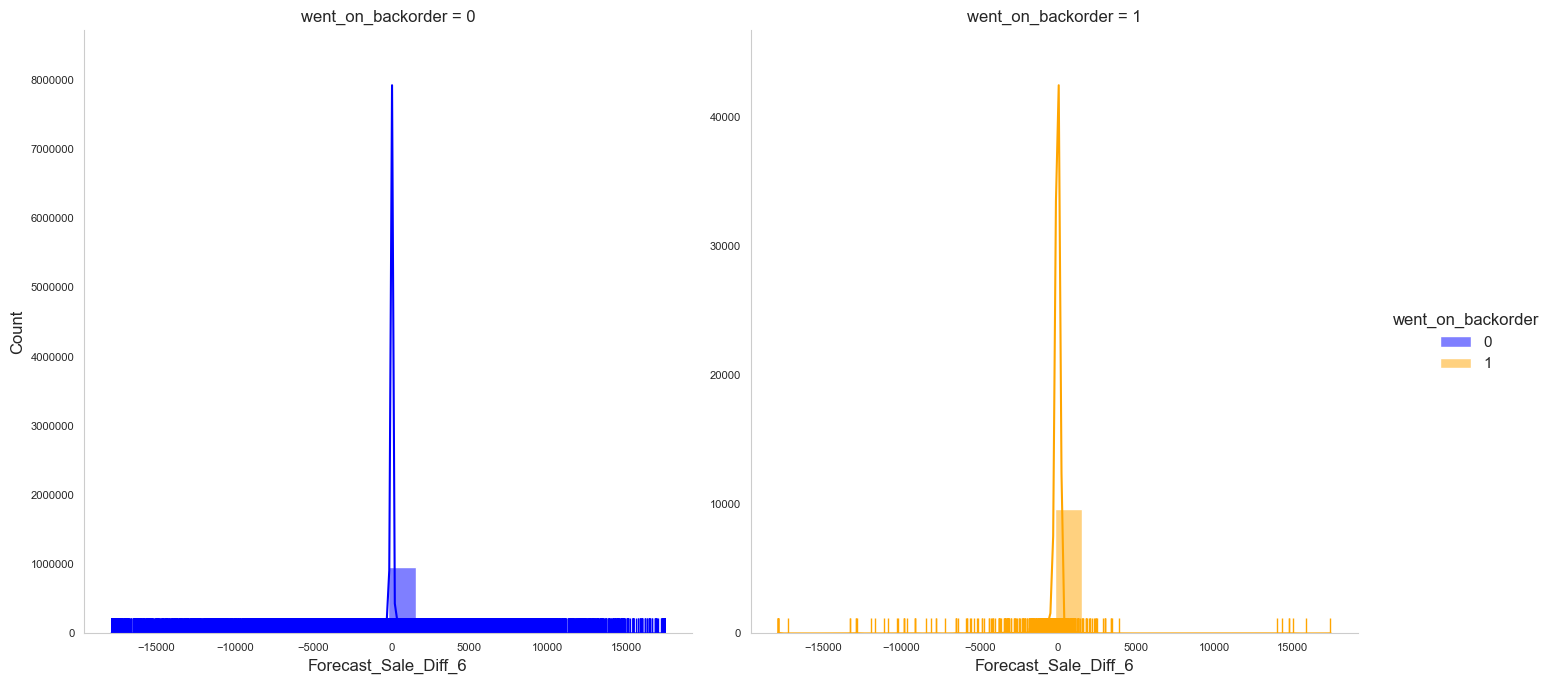

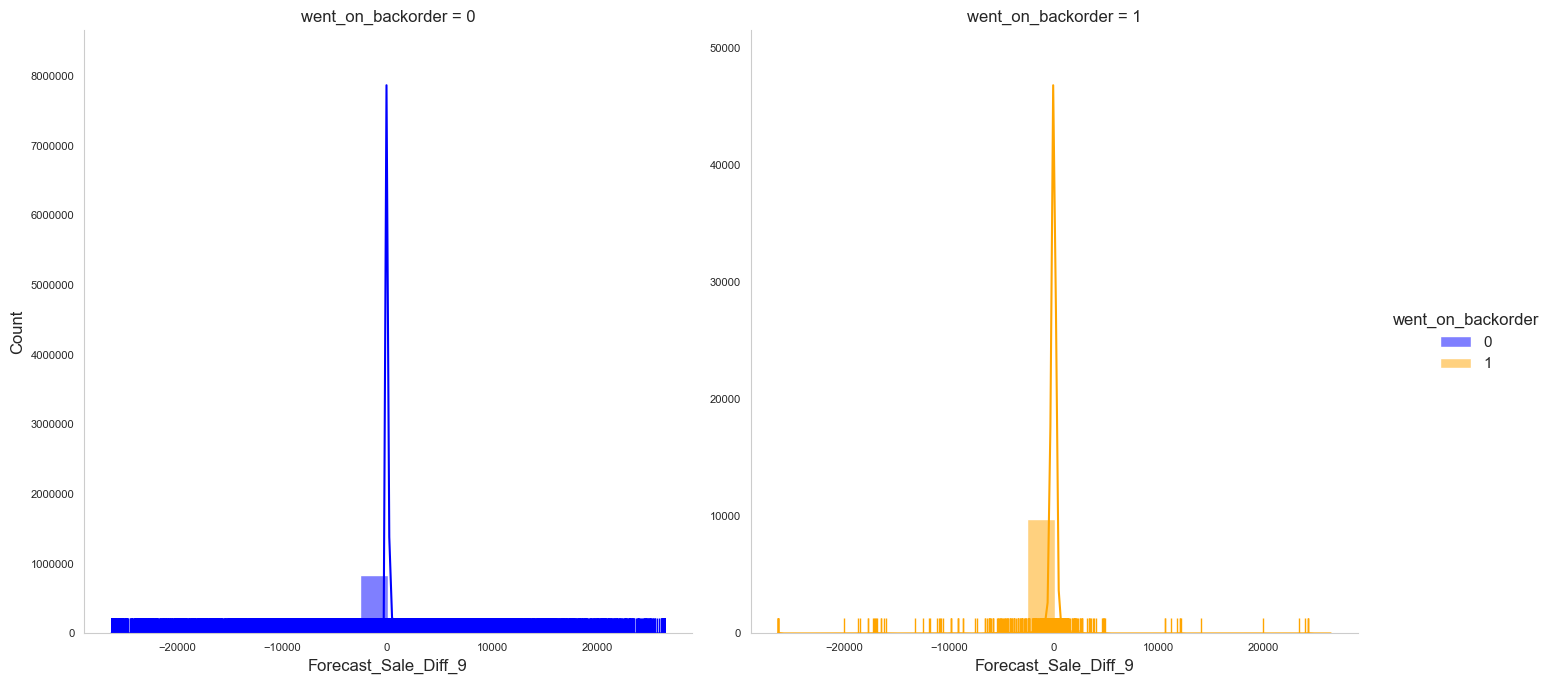

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))
sns.displot(data = train,x = 'Forecast_Sale_Diff_3',col = 'went_on_backorder',hue = 'went_on_backorder',bins = 20,rug=True,
            facet_kws={'sharey': False},palette = ['blue','orange'],height=7,aspect=1,kde=True, ax=ax[0])
#ax[0].set_title("Forecast_Sale_Diff_3 by the backorder", fontsize=14)

sns.displot(data = train,x = 'Forecast_Sale_Diff_6',col = 'went_on_backorder',hue = 'went_on_backorder',bins = 20,rug=True,
            facet_kws={'sharey': False},palette = ['blue','orange'],height=7,aspect=1,kde=True, ax=ax[1])
#ax[1].set_title("Forecast_Sale_Diff_6 by the backorder", fontsize=14)

sns.displot(data = train,x = 'Forecast_Sale_Diff_9',col = 'went_on_backorder',hue = 'went_on_backorder',bins = 20,rug=True,
            facet_kws={'sharey': False},palette = ['blue','orange'],height=7,aspect=1,kde=True, ax=ax[2])
#ax[2].set_title("Forecast_Sale_Diff_9 by the backorder", fontsize=14)

#plt.show()


In [109]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

def valdiate_feature_imp(columns):
    for col in columns:
        '''returns AUC and PR-AUC of logit model trained on the provided column'''
    
        x_train, x_test,y_train,y_test = train_test_split(train[col],train['went_on_backorder'], test_size =0.3, stratify=train['went_on_backorder'])
    
    
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train.values.reshape(-1,1))
        x_test = scaler.transform(x_test.values.reshape(-1,1))

        clf = LogisticRegression()
        clf.fit(x_train, y_train)

        pred_cv_proba = clf.predict_proba(x_test)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_cv_proba[:,1])
        precision_train, recall_train, _ = precision_recall_curve(y_test, pred_cv_proba[:,1])
        print('for i = ',1)
        print('-'*20)
        print('AUC:: ',round(metrics.auc(fpr, tpr),3))
        print('PR-AUC score ::',round(auc(recall_train, precision_train),3),'\n')
        

### min_bank and national_inv difference

In [98]:
train['min_bank_diff'] =  train['min_bank'] - train['national_inv']

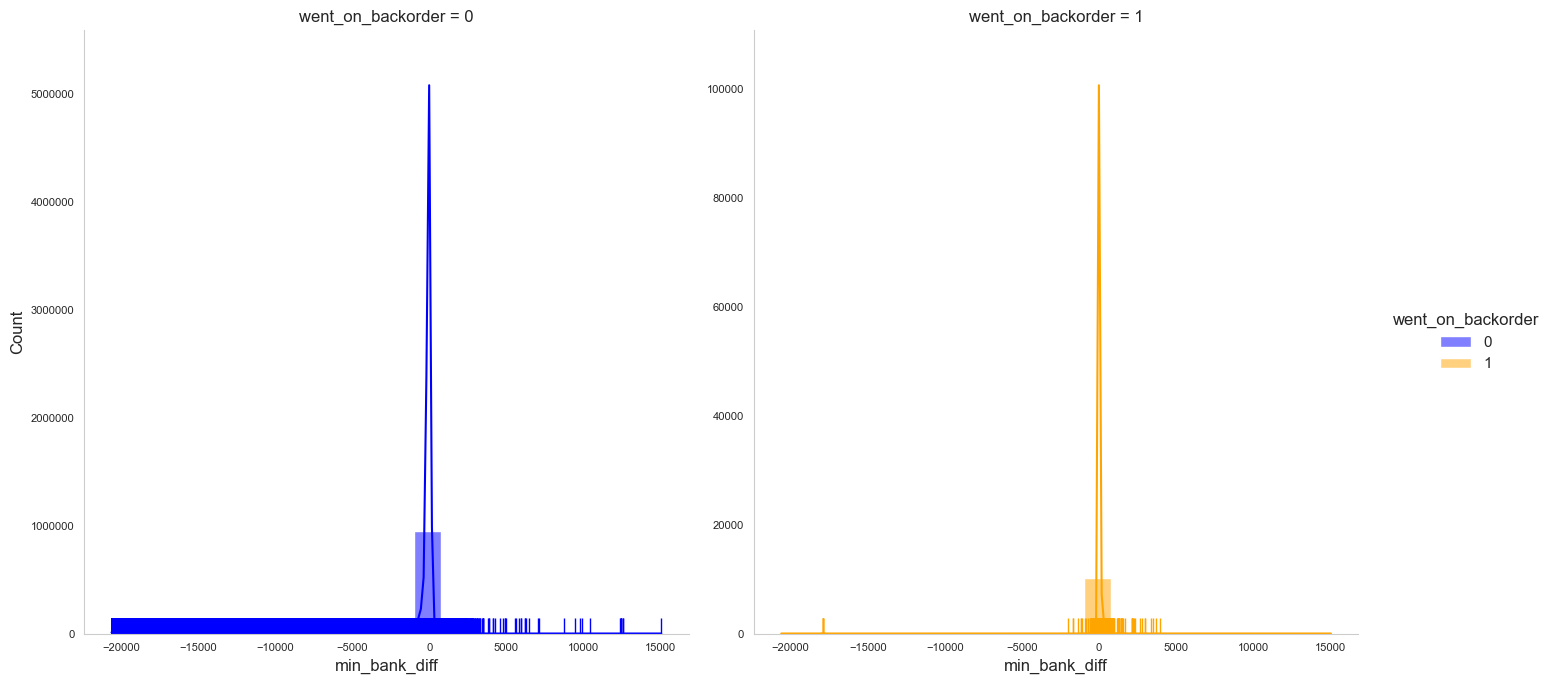

In [99]:
sns.displot(data = train,x = 'min_bank_diff',col = 'went_on_backorder',hue = 'went_on_backorder',bins = 20,rug=True,
            facet_kws={'sharey': False},palette = ['blue','orange'],height=7,aspect=1,kde=True, ax=ax[2])

In [110]:
cols = ['min_bank','min_bank_diff']
valdiate_feature_imp(cols)

for i =  1
--------------------
AUC::  0.579
PR-AUC score :: 0.258 

for i =  1
--------------------
AUC::  0.878
PR-AUC score :: 0.059 



In [ ]:
#### Performance Difference

In [111]:
train['perf_diff'] = train.perf_12_month_avg - train.perf_6_month_avg

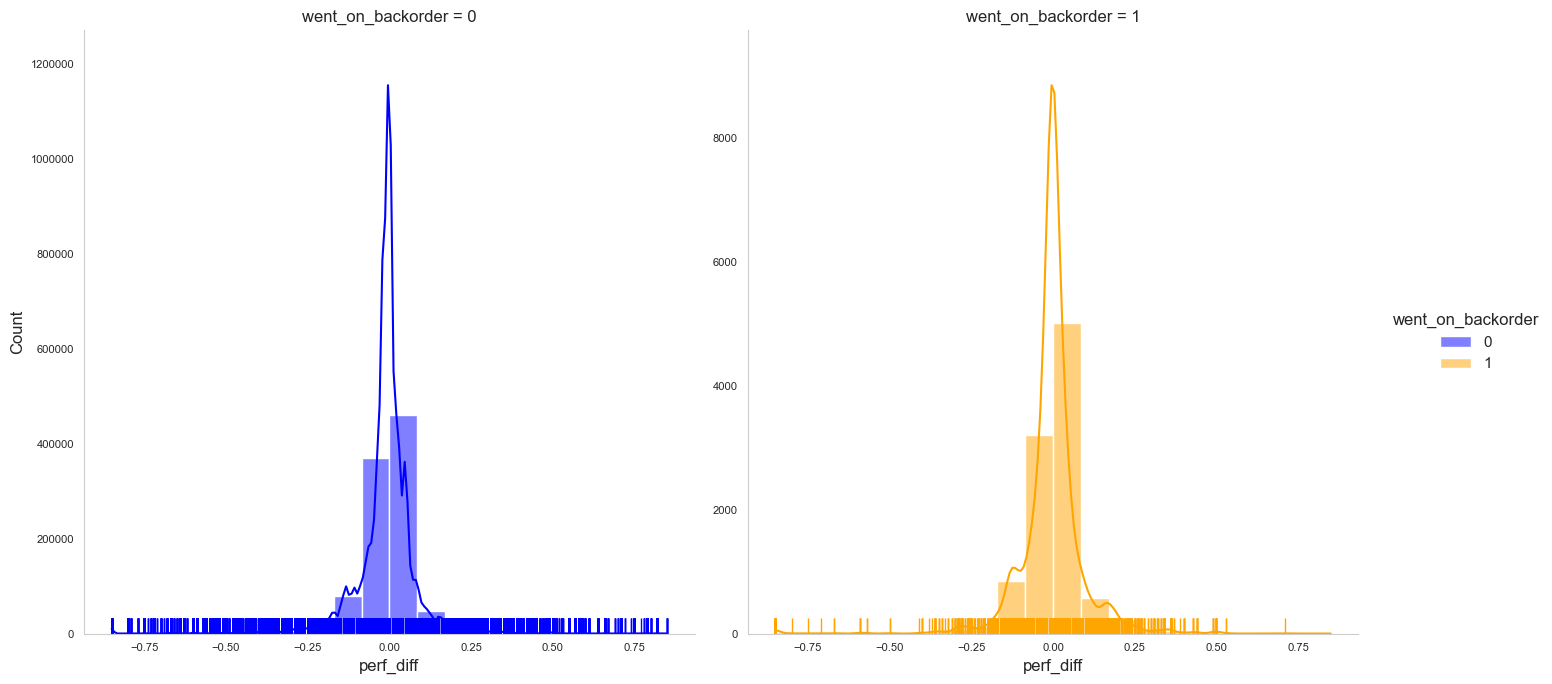

In [112]:
sns.displot(data = train,x = 'perf_diff',col = 'went_on_backorder',hue = 'went_on_backorder',bins = 20,rug=True,
            facet_kws={'sharey': False},palette = ['blue','orange'],height=7,aspect=1,kde=True, ax=ax[2])

In [113]:
cols =['perf_6_month_avg', 'perf_12_month_avg','perf_diff']
valdiate_feature_imp(cols)

for i =  1
--------------------
AUC::  0.596
PR-AUC score :: 0.036 

for i =  1
--------------------
AUC::  0.595
PR-AUC score :: 0.038 

for i =  1
--------------------
AUC::  0.523
PR-AUC score :: 0.011 



In [114]:
train.drop(columns=['Forecast_Sale_Diff_6', 'Forecast_Sale_Diff_9', 'perf_diff'], inplace=True, axis=1)

In [115]:
train.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,Forecast_Sale_Diff_3,min_bank_diff
0,0.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.83008,0.00000,0,No,0,0,0,0,0.00000,0.00000
1,2.00000,9.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.99023,0.00000,0,No,0,0,0,0,0.00000,-2.00000
2,2.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.83008,0.00000,1,No,0,0,0,0,0.00000,-2.00000
3,7.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.13000,0.00000,0,No,0,0,0,0,0.00000,-6.00000
4,8.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.00000,...,0.83008,0.00000,1,No,0,0,0,0,0.00000,-6.00000


In [116]:
### Bin the lead time

In [117]:
train['lead_time'] = train['lead_time'].astype(int)

In [118]:
train['leadtimebin'] = pd.cut(train.lead_time, 5, labels=['verylow', 'low', 'medium', 'high', 'veryhigh'])

In [123]:
from sklearn.preprocessing import LabelEncoder
train['leadtimebin'] = LabelEncoder().fit_transform(train.leadtimebin)

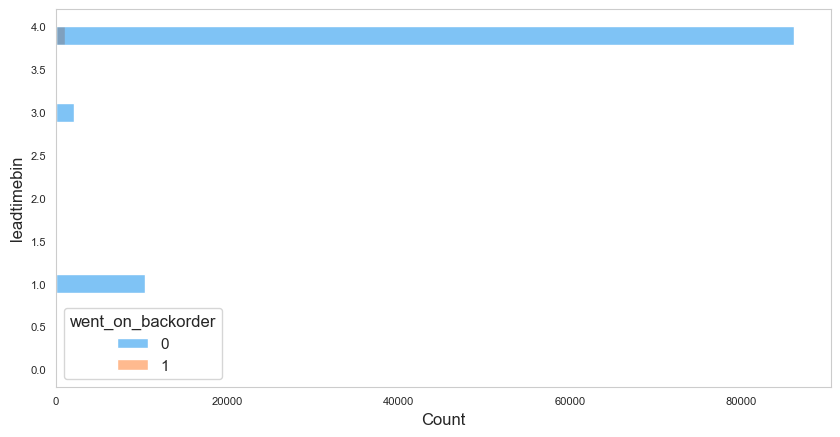

In [124]:
plt.figure(figsize=(10,5))
sns.histplot(hue='went_on_backorder', y='leadtimebin', data=train[:100000])
plt.show()

In [125]:
cols =['lead_time', 'leadtimebin']
valdiate_feature_imp(cols)

for i =  1
--------------------
AUC::  0.546
PR-AUC score :: 0.021 

for i =  1
--------------------
AUC::  0.488
PR-AUC score :: 0.009 



In [126]:
test['Forecast_Sale_Diff_3'] =  test['sales_3_month'] - test['forecast_3_month']
test['min_bank_diff'] =  test['min_bank'] - test['national_inv']


test['lead_time'] = test['lead_time'].astype(int)
test['leadtimebin'] = pd.cut(test.lead_time, 5, labels=['verylow', 'low', 'medium', 'high', 'veryhigh'])
test['leadtimebin'] = LabelEncoder().fit_transform(test.leadtimebin)



In [127]:
## Create a new col for lead time based on bin, so droping the original feature

train.drop(columns='lead_time', inplace=True, axis=1)
test.drop(columns='lead_time', inplace=True, axis=1)

### Corelated Variables

In [128]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,national_inv,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,...,perf_12_month_avg,local_bo_qty,deck_risk,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,Forecast_Sale_Diff_3,min_bank_diff,leadtimebin
national_inv,1.00000,0.38612,0.42703,0.45721,0.46576,0.46439,0.48194,0.49100,0.49780,0.49128,...,0.02338,0.04016,0.02536,0.00366,0.05062,0.00294,0.02209,0.03802,0.99254,0.00733
in_transit_qty,0.38612,1.00000,0.69633,0.71502,0.71680,0.73462,0.73976,0.73694,0.73309,0.71550,...,0.01775,0.08091,0.07233,0.00803,0.01062,0.00016,0.01687,0.01081,0.30965,0.01749
forecast_3_month,0.42703,0.69633,1.00000,0.97145,0.95678,0.80860,0.81542,0.81307,0.81072,0.79742,...,0.02695,0.11449,0.07533,0.01154,0.00829,0.00314,0.00286,0.40547,0.34162,0.00982
forecast_6_month,0.45721,0.71502,0.97145,1.00000,0.99151,0.83030,0.84429,0.84642,0.84302,0.82032,...,0.03261,0.10925,0.07965,0.01234,0.01303,0.00118,0.00590,0.31155,0.37043,0.01400
forecast_9_month,0.46576,0.71680,0.95678,0.99151,1.00000,0.83677,0.85355,0.85641,0.85150,0.82490,...,0.03516,0.10599,0.08151,0.01297,0.01510,0.00016,0.00731,0.27208,0.37887,0.01455


In [129]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,national_inv,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,...,perf_12_month_avg,local_bo_qty,deck_risk,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,Forecast_Sale_Diff_3,min_bank_diff,leadtimebin
national_inv,NaN,0.38612,0.42703,0.45721,0.46576,0.46439,0.48194,0.49100,0.49780,0.49128,...,0.02338,0.04016,0.02536,0.00366,0.05062,0.00294,0.02209,0.03802,0.99254,0.00733
in_transit_qty,NaN,NaN,0.69633,0.71502,0.71680,0.73462,0.73976,0.73694,0.73309,0.71550,...,0.01775,0.08091,0.07233,0.00803,0.01062,0.00016,0.01687,0.01081,0.30965,0.01749
forecast_3_month,NaN,NaN,NaN,0.97145,0.95678,0.80860,0.81542,0.81307,0.81072,0.79742,...,0.02695,0.11449,0.07533,0.01154,0.00829,0.00314,0.00286,0.40547,0.34162,0.00982
forecast_6_month,NaN,NaN,NaN,NaN,0.99151,0.83030,0.84429,0.84642,0.84302,0.82032,...,0.03261,0.10925,0.07965,0.01234,0.01303,0.00118,0.00590,0.31155,0.37043,0.01400
forecast_9_month,NaN,NaN,NaN,NaN,NaN,0.83677,0.85355,0.85641,0.85150,0.82490,...,0.03516,0.10599,0.08151,0.01297,0.01510,0.00016,0.00731,0.27208,0.37887,0.01455


In [130]:
# Select columns with correlations above threshold
colname = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns having more than 90 percentage corelation.' % (len(colname)))
print(colname)

There are 7 columns having more than 90 percentage corelation.
['forecast_6_month', 'forecast_9_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'perf_12_month_avg', 'min_bank_diff']


### Checking feature importance using LGBM classifer

In [131]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1]-1)
train_labels = train["went_on_backorder"]

# Create the model with several hyperparameters
model = LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 100, class_weight = 'balanced')

In [132]:
# Fit the model twice to avoid overfitting
def featureImportance(train, test, model):
    train_labels = train["went_on_backorder"]
    X = train.drop(columns="went_on_backorder")
    y = train['went_on_backorder']
    #X_test = test.drop(columns="went_on_backorder")
    #y_test = test['went_on_backorder']
    
    feature_importances = np.zeros(train.shape[1]-1)


    for i in range(2):
    
        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.25, random_state = i)
        
        
        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                     eval_metric = 'auc', verbose = 200)

    
        # Record the feature importances
        feature_importances += model.feature_importances_
        
    return feature_importances

In [133]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [139]:
train

,national_inv,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,...,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,Forecast_Sale_Diff_3,min_bank_diff,leadtimebin
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0,No,0,0,0,0,0.00000,0.00000,4
1,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0,No,0,0,0,0,0.00000,-2.00000,4
2,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,1,No,0,0,0,0,0.00000,-2.00000,4
3,7.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0,No,0,0,0,0,0.00000,-6.00000,4
4,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.00000,2.00000,...,0.00000,1,No,0,0,0,0,0.00000,-6.00000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687855,0.00000,0.00000,10.00000,10.00000,10.00000,0.00000,5.00000,7.00000,7.00000,0.00000,...,5.00000,1,No,0,0,0,0,-5.00000,0.00000,4
1687856,-1.00000,0.00000,5.00000,7.00000,9.00000,1.00000,3.00000,3.00000,8.00000,0.00000,...,1.00000,0,No,0,0,0,0,-2.00000,1.00000,4
1687857,-1.00000,0.00000,7.00000,9.00000,11.00000,0.00000,8.00000,11.00000,12.00000,0.00000,...,1.00000,1,No,0,1,0,1,1.00000,1.00000,4
1687858,62.00000,16.00000,39.00000,87.00000,126.00000,35.00000,63.00000,153.00000,205.00000,12.00000,...,6.00000,0,No,0,0,0,0,24.00000,-50.00000,4


In [141]:
feature_importances = featureImportance(train, test, model)

In [142]:
# Make sure to average feature importances! 
X = train.drop(columns=["went_on_backorder"], axis=1)
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head(10)

,feature,importance
0,national_inv,352.50000
13,perf_12_month_avg,259.50000
12,perf_6_month_avg,243.00000
5,sales_1_month,242.00000
1,in_transit_qty,234.50000
8,sales_9_month,232.50000
21,min_bank_diff,212.50000
9,min_bank,178.00000
20,Forecast_Sale_Diff_3,172.00000
6,sales_3_month,161.50000


In [143]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 1 features with 0.0 importance


,feature,importance
17,ppap_risk,25.50000
11,pieces_past_due,25.50000
19,rev_stop,10.50000
10,potential_issue,1.00000
16,oe_constraint,0.00000


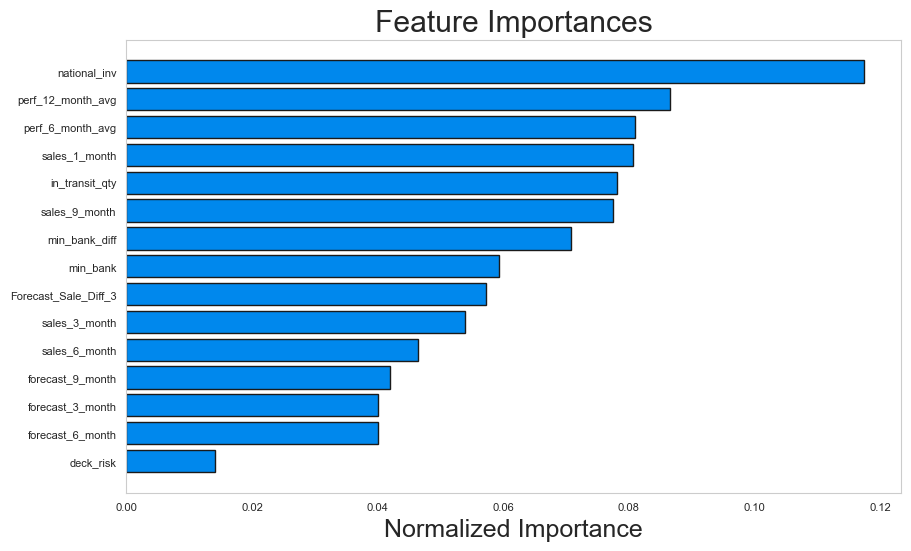

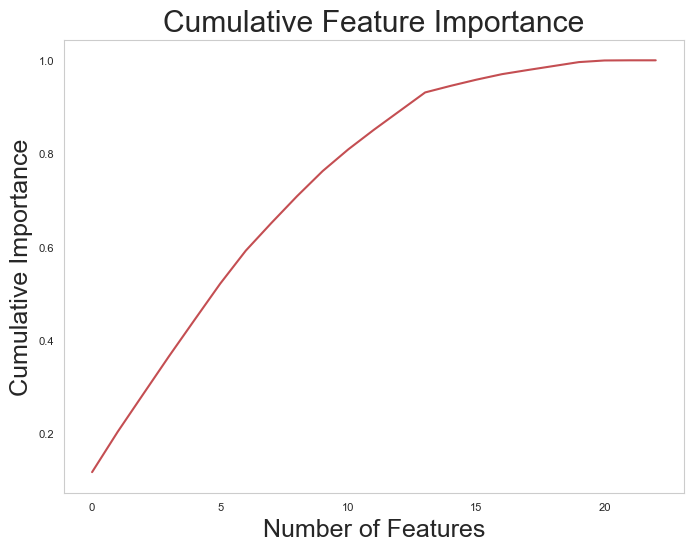

14 features required for 0.90 of cumulative importance


In [144]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [145]:
#### droping the least important feature as these will help in under-over sampling through dimension reduction

train.drop(columns=['potential_issue', 'oe_constraint'], inplace=True, axis=1)
test.drop(columns=['potential_issue', 'oe_constraint'], inplace=True, axis=1)

In [146]:
train.shape, test.shape

((1020037, 22), (185366, 22))

In [147]:
train.head()

,national_inv,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,...,perf_12_month_avg,local_bo_qty,deck_risk,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,Forecast_Sale_Diff_3,min_bank_diff,leadtimebin
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.83008,0.00000,0,0,0,0,0,0.00000,0.00000,4
1,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.99023,0.00000,0,0,0,0,0,0.00000,-2.00000,4
2,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.83008,0.00000,1,0,0,0,0,0.00000,-2.00000,4
3,7.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.13000,0.00000,0,0,0,0,0,0.00000,-6.00000,4
4,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.00000,2.00000,...,0.83008,0.00000,1,0,0,0,0,0.00000,-6.00000,4


### PCA performance to check dimensional reduction

In [148]:
from sklearn.decomposition import PCA
# Since PCA uses the covariance matrix to derive eigenvectors
# and eigenvalues (or in some cases, Singular Value Decomposition),
# our dataset must be numeric so the algorithm can work properly
    
numeric_df = train.drop(columns=['went_on_backorder'], axis=1)  
test_df = test.drop(columns=['went_on_backorder'], axis=1)  
# Defining a PCA Pipeline that will return transformed numeric columns
def definePCAPipeline(numeric_columns):

    # 1st -> Numeric Transformer
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # 2nd -> Putting the scaling transformation step into a ColumnTransformer object
    data_transformations = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_columns)])
    
    # 3rd -> Final PCA Pipeline
    pca_pipeline = Pipeline(steps=[('data_transformations', data_transformations),
                                   ('feature_transf', PCA(n_components=15, whiten=True))])
    
    return pca_pipeline


In [149]:
train.drop(columns=['went_on_backorder'], axis=1).columns

Index(['national_inv', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'deck_risk', 'ppap_risk', 'stop_auto_buy', 'rev_stop',
       'Forecast_Sale_Diff_3', 'min_bank_diff', 'leadtimebin'],
      dtype='object')

In [150]:

# Generating transformed data after PCA, only 2 principal components chosen
col_name = train.drop(columns=['went_on_backorder'], axis=1).columns
pca_pipeline = definePCAPipeline(col_name)
pca_arr = pca_pipeline.fit_transform(numeric_df) # Only numeric data passed to PCA

# How much variance does our PCA obtained components explains from the original variance in data?
# Note that we need to pass only numeric data to our PCA pipeline, so the total variance does not include categorical data
comp1 = pca_pipeline[1].explained_variance_ratio_[0] # First principal component
comp2 = pca_pipeline[1].explained_variance_ratio_[1] # Second principal component
comp3 = pca_pipeline[1].explained_variance_ratio_[2] # Third principal component
comp4 = pca_pipeline[1].explained_variance_ratio_[3] # Fourth principal component
comp5 = pca_pipeline[1].explained_variance_ratio_[4] # fifth principal component
comp6 = pca_pipeline[1].explained_variance_ratio_[5] # Sixth principal component
comp7 = pca_pipeline[1].explained_variance_ratio_[6] # Fourth principal component
comp8 = pca_pipeline[1].explained_variance_ratio_[7] # fifth principal component
comp9 = pca_pipeline[1].explained_variance_ratio_[8] # Sixth principal component
comp10 = pca_pipeline[1].explained_variance_ratio_[9] # Fourth principal component
comp11= pca_pipeline[1].explained_variance_ratio_[10] # fifth principal component
comp12 = pca_pipeline[1].explained_variance_ratio_[11] # Sixth principal component
comp13 = pca_pipeline[1].explained_variance_ratio_[12] # Fourth principal component
comp14= pca_pipeline[1].explained_variance_ratio_[13] # fifth principal component
comp15 = pca_pipeline[1].explained_variance_ratio_[14] # Sixth principal component
exp_variance_pca = comp1 + comp2 + comp3 + comp4 + comp5 + comp6 + comp7 + comp8 + comp9 + comp10 + comp11 + comp12 + comp13 + comp14 + comp15

print("Compontent 1 explained variance ratio:", comp1)
print("Compontent 2 explained variance ratio:", comp2)
print("Compontent 3 explained variance ratio:", comp3)
print("Compontent 4 explained variance ratio:", comp4)
print("Compontent 5 explained variance ratio:", comp5)
print("Compontent 6 explained variance ratio:", comp6)
print("Compontent 7 explained variance ratio:", comp7)
print("Compontent 8 explained variance ratio:", comp8)
print("Compontent 9 explained variance ratio:", comp9)
print("Compontent 10 explained variance ratio:", comp10)
print("Compontent 11 explained variance ratio:", comp11)
print("Compontent 12 explained variance ratio:", comp12)
print("Compontent 13 explained variance ratio:", comp13)
print("Compontent 14 explained variance ratio:", comp14)
print("Compontent 15 explained variance ratio:", comp15)
print("Total explained variance ratio obtained from 15 components:", exp_variance_pca)

Compontent 1 explained variance ratio: 0.39782713250719415
Compontent 2 explained variance ratio: 0.0955154476643126
Compontent 3 explained variance ratio: 0.07607873728036509
Compontent 4 explained variance ratio: 0.0675131873976745
Compontent 5 explained variance ratio: 0.052721641508118575
Compontent 6 explained variance ratio: 0.04795035110258307
Compontent 7 explained variance ratio: 0.04761796512546687
Compontent 8 explained variance ratio: 0.0467291289814424
Compontent 9 explained variance ratio: 0.04567825412129222
Compontent 10 explained variance ratio: 0.0448608299456362
Compontent 11 explained variance ratio: 0.03951051612577254
Compontent 12 explained variance ratio: 0.01826121542749936
Compontent 13 explained variance ratio: 0.007995587173154043
Compontent 14 explained variance ratio: 0.003776685917546865
Compontent 15 explained variance ratio: 0.003644884844834361
Total explained variance ratio obtained from 15 components: 0.995681565122893


Text(0, 0.5, 'Principal Components')

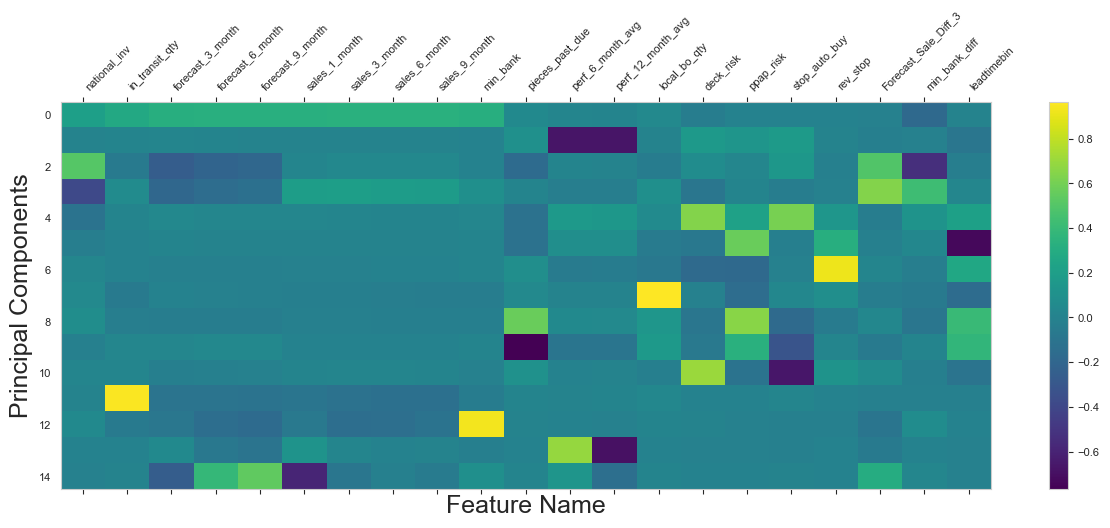

In [151]:
# Plotting how much each feature contributes to the Principal Components
plt.figure(figsize=(15,5))
plt.matshow(pca_pipeline[1].components_, cmap='viridis', fignum=1, aspect='auto')
#plt.yticks([0, 2], ['Principal Component 1', 'Principal Component 2'])
plt.colorbar()
plt.xticks(range(len(col_name)), col_name, rotation=45, ha='left', )
plt.xlabel('Feature Name')
plt.ylabel('Principal Components')

<Figure size 600x400 with 0 Axes>

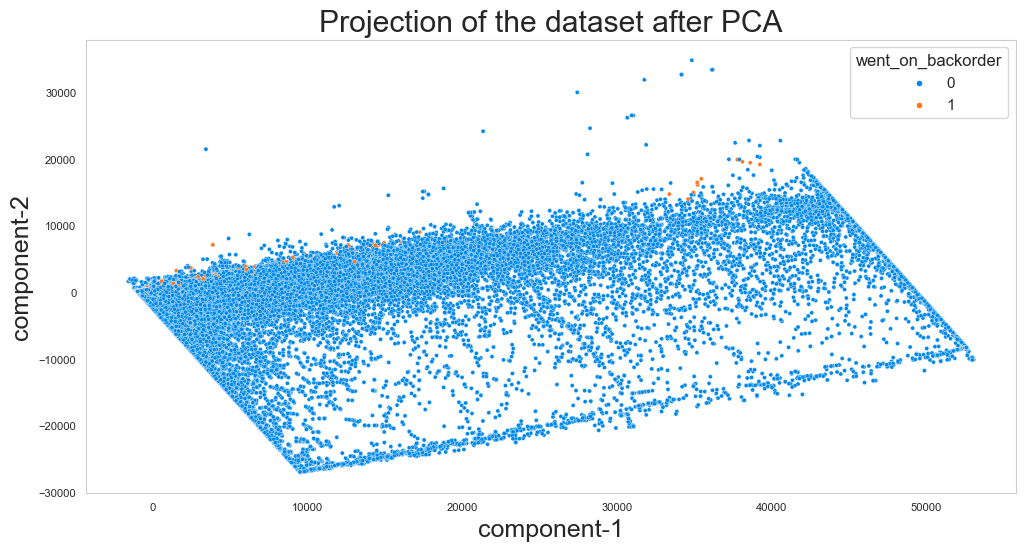

In [152]:
# Make sure to drop the ids and target
ptrain = train.drop(columns = ['went_on_backorder'], axis=1)
ptest = test.drop(columns = ['went_on_backorder'], axis=1)

# Make a pipeline with imputation and pca
pca = PCA(n_components=2).fit_transform(ptrain)

plt.clf();
plt.figure(figsize=(12,6))
sns.scatterplot(x = pca[:,0],y=pca[:,1],hue = train['went_on_backorder'])
plt.xlabel('component-1')
plt.ylabel('component-2')
plt.title('Projection of the dataset after PCA')
plt.show()

In [153]:
#### Save the dataset for modeling

In [154]:
train.to_csv('train.csv')
test.to_csv('test.csv')